# Classificação em aprendizado de máquina supervisionado com geometria computacional
    Gabriel Lima Barros - 2020006531
    Gabriel Teixeira Carvalho - 2020006558
    Thiago Pádua de Carvalho - 2020007066

## Problema Proposto
O trabalho lida com o problema de implementar um classificador utilizando aprendizado de máquina supervisionado. 

O objetivo principal desta tarefa é criar um programa que, dado um conjunto de dados com 2 colunas de atributos e 1 coluna de classe, consiga classificar novos dados em uma das duas classes disponíveis. 

Para resolver o problema citado, foram utilizados algoritmos de geometria computacional aprendidos na disciplina de Algoritmos II.

Ao longo deste notebook, serão apresentadas as implementações dos algoritmos utilizados para a solução do problema. Além disso, serão apresentados os resultados obtidos com a execução do programa, utilizando métricas comuns em aprendizado de máquina. Por fim, serão apresentadas as conclusões (e possíveis melhorias para o programa)?.

### Importando as bibliotecas

In [66]:
from random import random, choice
from functools import cmp_to_key
from bintrees import RBTree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

### Problema da Envoltória Convexa
O problema da envoltória convexa trata de encontrar o menor polígono convexo possível a partir de um dado conjunto de pontos. Sua solução fornece os vértices que compõem o polígono que contém todos os pontos.

No contexto do classificador utilizando aprendizado de máquina, computaremos a envoltória de cada uma das classes de modo a gerar os modelos lineares e verificar a separabilidade dos dados.

### Implementação do Algoritmo de Graham Scan
O algoritmo seleciona um ponto âncora e, a partir dele, ordena os demais de acordo com os seus ângulos polares. 
Para manter os vértices da envoltória no momento do processamento, utliza-se uma pilha como estrutura de dados, inicialmente, a âncora e os seus dois sucessores ordenados são inseridos e inicia-se a computação.
Processamos cada um dos vértices em sentido anti-horário e verificamos se há mudança de direção para a esquerda em Pi quando seguimos pelo caminho Pi-1 - Pi - Pi+1.
Caso haja, adicionamos o ponto à pilha e prosseguimos.
Caso não haja, Pi é um vértice interno e, portanto não faz parte da envoltória. Removemos Pi da pilha e testamos novamente o caminho Pi-1 - Pi - Pi+1.

O algoritmo finaliza quando todos os pontos são avaliados.

A complexidade é O(n log n), determinada pela ordenação dos pontos.



Primeiramente, definimos uma classe que representa um ponto no plano cartesiano. Essa classe possui os atributos x e y, que representam as coordenadas do ponto.

In [67]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.isLeftEndpoint = False
    self.segmentId = None
  
  def __str__(self):
    return "(" + str(self.x) + ", " + str(self.y) + ")"

def printPointList(points):
  for p in points:
    print(p, end=" ")
  print()

Definimos uma função que calcula a orientação de três pontos. Essa função recebe três pontos (p0, p1 e p2) e retorna uma string representando a orientação dos segmentos *p0-p1* e *p0-p2*. Se a orientação for "left", então os três pontos estão em sentido anti-horário. Se a orientação for "right", então os três pontos estão em sentido horário. Se a orientação for "collinear", então os três pontos estão colineares.

In [68]:
def findOrientation(p0, p1, p2):
  crossProduct = (p1.x - p0.x) * (p2.y - p0.y) - (p2.x - p0.x) * (p1.y - p0.y)
  if crossProduct == 0:
    return "collinear"
  elif crossProduct > 0:
    return "right"
  else:
    return "left"

Definimos uma função que encontra a âncora previamente citada, isto é, o ponto com menor coordenada y. Essa função recebe um conjunto de pontos e retorna o ponto com menor coordenada y. Caso haja mais de um ponto com a menor coordenada y, então o ponto com menor coordenada x é retornado.

In [69]:
def findBottomMostPoint(points):
  bottomMostPoint = points[0]

  for p in points:
    if p.y < bottomMostPoint.y or (p.y == bottomMostPoint.y and p.x < bottomMostPoint.x):
      bottomMostPoint = p

  return bottomMostPoint

Definimos uma função que ordena os pontos de um conjunto de pontos. Essa função recebe um conjunto de pontos e retorna uma lista de pontos ordenados em ordem.

In [70]:
def findDistance(p0, p1):
  return ((p1.x - p0.x) ** 2 + (p1.y - p0.y) ** 2) ** 0.5

def sortPoints(points, bottomMostPoint):
  def comparePolarAngle(p1, p2):
    orientation = findOrientation(bottomMostPoint, p1, p2)
    if orientation == "collinear":
      if findDistance(bottomMostPoint, p1) <= findDistance(bottomMostPoint, p2):
        return -1
      else:
        return 1
    elif orientation == "right":
      return -1
    else:
      return 1
  sortedPoints = sorted(points, key = cmp_to_key(comparePolarAngle))
  return sortedPoints

def removeCollinearPoints(sortedPoints,bottomMostPoint):
  i = 0
  while i < len(sortedPoints) - 1:
    if findOrientation(bottomMostPoint, sortedPoints[i], sortedPoints[i + 1]) == "collinear":
      sortedPoints.pop(i)
    else:
      i += 1

Terminado o pré-precessamento, tem-se a formação da envoltória propriamente dita. "findConvexHull" implementa o algoritmo da Varredura de Graham e retorna os pontos de um conjunto que formam a envoltória convexa.

In [71]:
def findConvexHull(points):
    bottomMostPoint = findBottomMostPoint(points)
    points.remove(bottomMostPoint)
    sortedPoints = sortPoints(points, bottomMostPoint)
    removeCollinearPoints(sortedPoints, bottomMostPoint)
    sortedPoints = [bottomMostPoint] + sortedPoints

    if len(sortedPoints) < 3:
      print("Convex hull is not possible!")

    convexHull = [sortedPoints[0], sortedPoints[1], sortedPoints[2]]
    for i in range(3, len(sortedPoints)):
        while findOrientation(convexHull[-2], convexHull[-1], sortedPoints[i]) != "right":
            convexHull.pop()
        convexHull.append(sortedPoints[i])
    return convexHull

### O problema de decidir se dois segmentos em um conjunto se interceptam
Para decidir se as envoltórias são linearmente independente, será utlizado o problema de decidir se dois segmentos em um conjunto se interceptam. Caso exista interceptação em segmentos de envoltórias diferentes, temos que elas não são linearmente separáveis.

### Implementação Interceptação de Segmentos em um Conjuntos
Uma vez que temos os pontos que fazem parte da envoltória convexa precisamos transformá-los em segmentos, para isso foi definida uma classe para representá-los em um plano cartesiano e uma função que recebe os pontos que fazem parte de uma envoltória convexa e retorna os segmentos que limitam essa envoltória.

Uma vez realizado esse processamento, utilizaremos a varredura linear (sweeping) para reponder o problema.
Definimos uma ordem sobre os segmentos partindo da coordenada y de suas interceções com a reta de varredura.
Dois segmentos são comparáveis se a reta intercepta ambos os segmentos e eles são consecutivos, isto é, devem estar imediatamente acima ou abaixo um do outro, sem intermediários.
Para realizar as comparações, nos utilizamos de uma árvore binária balanceada - optamos pela rubro-negra - de modo a realizar operações de inserção, remoção, sucessor e antecessor imediato em tempo O(log n).
A relação é dinâmica e conforme acontecem eventos - inserção ou remoção - a reta de varredura avança sobre os segmentos e devemos realizar as operações na árvore. Quando temos dois segmentos consecutivos, verificamos através das primitivas geométricas se eles se interceptam. Caso a resposta seja positiva, temos dados não linearmente separáveis. Caso contrário, prosseguimos com o algoritmo. Se avaliarmos todos os elementos e não obtivermos interseção, os dados são separáveis.

Dentro da classe sobrescrevemos alguns operadores para possibilitar a inserção na árvore rubro-negra. Dessa forma os segmentos serão avaliados de acordo com a altura que se encontram no plano em comparação com os outros segmentos da árvore.

O custo total do algoritmo implementado é O(n log n) devido a ordenação feita no pré-processamento.

In [72]:
def onSegment(p1, p2, p3):
    if ((p3.x <= p2.x and p3.x >= p1.x) or (p3.x <= p1.x and p3.x >= p2.x)):
        if ((p3.y <= p2.y and p3.y >= p1.y) or (p3.y <= p1.y and p3.y >= p2.y)):
            return True
    return False

def segmentsIntersect(p1, p2, p3, p4):
    d1 = findOrientation(p3, p4, p1)
    d2 = findOrientation(p3, p4, p2)
    d3 = findOrientation(p1, p2, p3)
    d4 = findOrientation(p1, p2, p4)

    if ((d1 == 'right' and d2 == 'left') or (d1 == 'left' and d2 == 'right')) and ((d3 == 'right' and d4 == 'left') or (d3 == 'left' and d4 == 'right')): 
        return True
    elif d1 == 'collinear'and onSegment(p3,p4,p1):
        return True
    elif d2 == 'collinear'and onSegment(p3,p4,p2):
        return True
    elif d3 == 'collinear'and onSegment(p1,p2,p3):
        return True
    elif d4 == 'collinear'and onSegment(p1,p2,p4):
        return True
    else:
        return False


In [73]:
class Segment:
    def __init__(self, id, p1, p2, convexHullLabel):
        if p1.x < p2.x:
            self.p1 = Point(p1.x, p1.y)
            self.p2 = Point(p2.x, p2.y)
        else:
            self.p1 = Point(p2.x, p2.y)
            self.p2 = Point(p1.x, p1.y)
        self.p1.isLeftEndpoint = True
        self.p1.segmentId = id
        self.p2.segmentId = id
        self.convexHullLabel = convexHullLabel

    def __str__(self):
        return "(" + str(self.p1.x) + ", " + str(self.p1.y) + ", " + str(self.p1.isLeftEndpoint) + ") - (" + str(self.p2.x) + ", " + str(self.p2.y) + ", " + str(self.p2.isLeftEndpoint)+ ")" + " " + self.convexHullLabel
    
    # return if a segment is below another
    def __gt__(self, other):
        if (min(self.p1.x,other.p1.x)==self.p1.x):
                b = self
                a = other
        else:
            b = other
            a = self
        m2 = (b.p2.y - b.p1.y)/(b.p2.x - b.p1.x)
        m1 = (a.p2.y - a.p1.y)/(a.p2.x - a.p1.x)

        x0 = max(self.p1.x,other.p1.x)
        if not (segmentsIntersect(self.p1,self.p2, other.p1,other.p2)):
            if (findOrientation(b.p1, a.p1, b.p2) == 'right'):
                return True if b == self else False
            elif (findOrientation(b.p1, a.p1, b.p2) == 'left'):
                return False if b == self else True
        else:
            if b.p1.y - m2 * b.p1.x - a.p1.y + m1 * a.p1.x < (m1-m2) * x0:
                return True if b == self else False
            else:
                return False if b == self else True

def printSegments(segments):
    print()
    for segment in segments:
        print(segment)

def findSegments(convexHull, convexHullLabel):
    segments = []
    for i in range(len(convexHull) - 1):
        point1 = convexHull[i]
        point2 = convexHull[i + 1]
        segment = Segment(i, point1, point2, convexHullLabel)
        segments.append(segment)
    point1 = convexHull[-1]
    point2 = convexHull[0]
    segmentId = len(convexHull) - 1
    segments.append(Segment(segmentId, point1, point2, convexHullLabel))
    
    return segments

Com o intuito de auxiliar na varredura linear, definimos funções que checam se existem segmentos que se interceptam, utilizamos o algoritmo padrão para checar se segmentos se interceptam utilizando a função "findOrientation" e a função "onSegment" para checar se um ponto de um segmento fazia parte do outro.

In [74]:
def onSegment(p1, p2, p3):
    if ((p3.x <= p2.x and p3.x >= p1.x) or (p3.x <= p1.x and p3.x >= p2.x)):
        if ((p3.y <= p2.y and p3.y >= p1.y) or (p3.y <= p1.y and p3.y >= p2.y)):
            return True
    return False

def segmentsIntersect(p1, p2, p3, p4):
    d1 = findOrientation(p3, p4, p1)
    d2 = findOrientation(p3, p4, p2)
    d3 = findOrientation(p1, p2, p3)
    d4 = findOrientation(p1, p2, p4)

    if ((d1 == 'right' and d2 == 'left') or (d1 == 'left' and d2 == 'right')) and ((d3 == 'right' and d4 == 'left') or (d3 == 'left' and d4 == 'right')): 
        return True
    elif d1 == 'collinear'and onSegment(p3,p4,p1):
        return True
    elif d2 == 'collinear'and onSegment(p3,p4,p2):
        return True
    elif d3 == 'collinear'and onSegment(p1,p2,p3):
        return True
    elif d4 == 'collinear'and onSegment(p1,p2,p4):
        return True
    else:
        return False

Definimos funções para encontrar e ordenar os pontos finais dos segmentos da envoltória tendo o ponto final à esquerda precedência sobre o ponto final a direita.

In [75]:
def findSegmentsEndpoints(segments):
    endpoints = []
    for segment in segments:
        leftEndpoint = segment.p1
        rightEndpoint = segment.p2

        endpoints.append(leftEndpoint)
        endpoints.append(rightEndpoint)
    return endpoints

def sortEndpoints(endpoints):
    def compareEndpoints(p1, p2):
        if p1.x < p2.x:
            return -1
        elif p1.x > p2.x:
            return 1
        else:
            if p1.isLeftEndpoint and not p2.isLeftEndpoint:
                return -1
            elif not p1.isLeftEndpoint and p2.isLeftEndpoint:
                return 1
            else:
                if p1.y < p2.y:
                    return -1
                elif p1.y > p2.y:
                    return 1
                else:
                    return 0
    sortedEndpoints = sorted(endpoints, key = cmp_to_key(compareEndpoints))
    return sortedEndpoints

Definimos identificadores para os segmentos para que seja possível encontrarmos os segmentos a partir do seu ponto final em tempo constante.

In [76]:
def adjustBSegmentsId(segmentsB, segmentsA):
    for segment in segmentsB:
        segment.p1.segmentId += len(segmentsA)
        segment.p2.segmentId += len(segmentsA)

De modo a evitar a inserção de pontos iguais e retas verticais, fizemos perturbações nos pontos

In [77]:
def perturbateSegments(segments):
    for segment in segments:
        segment.p1.x += random() * 0.000001
        segment.p2.x += random() * 0.000001
    return segments

Dessa forma, definimos a função para determinar se há interseção entre segmentos de duas envoltórias diferentes, para isso utilizamos o algoritmo que determina se há interseção entre segmentos dentro de um conjunto e adaptamos, adicionando rótulos aos segmentos para definir à qual envoltória eles pertenciam, se fossem da mesma a interseção era ignorada, mas se fossem de envoltórias diferentes então deveria ser retornada a existência de uma interseção.

In [78]:
def anySegmentsIntersectTree(convexHullA, convexHullB):
    tree = RBTree()
    AHullSegments = findSegments(convexHullA, "A")
    BHullSegments = findSegments(convexHullB, "B")
    adjustBSegmentsId(BHullSegments, AHullSegments)
    allSegments = perturbateSegments(AHullSegments + BHullSegments)
    allEndpoints = findSegmentsEndpoints(allSegments)
    sortedEndpoints = sortEndpoints(allEndpoints)

    for endpoint in sortedEndpoints:
        if endpoint.isLeftEndpoint:
            segment = allSegments[endpoint.segmentId]
            tree.insert(segment, endpoint.segmentId)
            if (tree.min_key() != segment):
                segmentBelow = tree.prev_key(segment)
                if (segment.convexHullLabel != segmentBelow.convexHullLabel and segmentsIntersect(segment.p1, segment.p2, segmentBelow.p1, segmentBelow.p2)):
                    return True
            if (tree.max_key() != segment):
                segmentAbove = tree.succ_key(segment)
                if (segment.convexHullLabel != segmentAbove.convexHullLabel and segmentsIntersect(segment.p1, segment.p2, segmentAbove.p1, segmentAbove.p2)):
                    return True
        if not endpoint.isLeftEndpoint:
            segment = allSegments[endpoint.segmentId]
            if (tree.min_key() != segment):
                segmentBelow = tree.prev_key(segment)
                if (tree.max_key() != segment):
                    segmentAbove = tree.succ_key(segment)
                    if (segmentBelow.convexHullLabel != segmentAbove.convexHullLabel and segmentsIntersect(segmentBelow.p1, segmentBelow.p2, segmentAbove.p1, segmentAbove.p2)):
                        return True
            tree.remove(segment)
    return False

In [79]:
def contains(p,convexHull):
    crossings = 0
    for i in range(len(convexHull)-1):
        slope = (convexHull[i+1].y - convexHull[i].y)/(convexHull[i+1].x - convexHull[i].x)
        cond1 = (convexHull[i].x <= p.x) and (p.x < convexHull[i+1].x)
        cond2 = (convexHull[i+1].x <= p.x) and (p.x < convexHull[i].x)
        above = (p.y < slope *(p.x - convexHull[i].x) + convexHull[i].y)
        if ((cond1 or cond2) and above ):
            crossings += 1
    return crossings % 2 != 0

O próximo passo foi traçar a reta que separa as duas envoltórias, para isso criamos uma função que encontra o par de pontos mais próximo entre as envoltórias e calculamos a reta mediatriz do segmento formado por esses dois pontos. Essa reta intercepta o segmento formado pelos dois pontos de forma perpendicular, separando os pontos se não houver interseção.

In [80]:
def findClosestPairOfPoints(convexHullA, convexHullB):
    closestDistance = float("inf")
    closestPair = None
    for i in range(len(convexHullA)):
        for j in range(len(convexHullB)):
            distance = findDistance(convexHullA[i], convexHullB[j])
            if distance < closestDistance:
                closestDistance = distance
                closestPair = Segment("", convexHullA[i], convexHullB[j], "")
    return closestPair

In [81]:
def findBisector(segment, x):
    x1 = (segment.p1.x + segment.p2.x)/2
    y1 = (segment.p1.y + segment.p2.y)/2
    if (segment.p2.x - segment.p1.x) == 0:
        m = 0
    elif (segment.p2.y - segment.p1.y) == 0:
        return None, 'vertical', x1
    else:
        originalM = (segment.p2.y - segment.p1.y)/(segment.p2.x - segment.p1.x)
        m = -1/originalM
    y = m * (x - x1) + y1
    b = m * -1 * x1 + y1
    return y, 'regular', [m, b]

### Plotagem 
Abaixo são definidas as funções necessárias para a representação gráfica da solução do problema. As envoltórias são contornadas em azul ou vermelho, tais como os seus pontos. A reta que as divide aparece em verde.

In [82]:
def findMinX(convexHull):
    return min(convexHull, key=lambda point: point.x).x

def findMaxX(convexHull):
    return max(convexHull, key=lambda point: point.x).x

def findXInterval(convexHull):
    diff = abs(findMaxX(convexHull) - findMinX(convexHull))
    return (findMinX(convexHull) - diff * 0.25, findMaxX(convexHull) + diff * 0.25)

def findMinY(convexHull):
    return min(convexHull, key=lambda point: point.y).y

def findMaxY(convexHull):
    return max(convexHull, key=lambda point: point.y).y

def findYInterval(convexHull):
    diff = abs(findMaxY(convexHull) - findMinY(convexHull))
    return (findMinY(convexHull) - diff * 0.25, findMaxY(convexHull) + diff * 0.25)

def plotConvexHull(points, convexHull, color):
    x = [point.x for point in points]
    y = [point.y for point in points]
    plt.scatter(x, y, color=color)
    for i in range(len(convexHull)):
        p1 = convexHull[i]
        p2 = convexHull[(i + 1) % len(convexHull)]
        plt.plot([p1.x, p2.x], [p1.y, p2.y], color, marker='o')

def sortSetsByBottomLeftPoint(points, points2):
    bottomLeftPoint = min(points + points2, key=lambda point: [point.y, point.x])
    if bottomLeftPoint in points:
        return points, points2
    else:
        return points2, points

### Input dos dados para a Solução Encontrada
A seguir, recebemos as entradas dos dados reais para plotagem, avaliação e obtenção de seus modelos. É importante notar que dividimos os dados de acordo com as suas classes - que podem ser 0 ou 1 - do dataframe e, então, obtemos seus respectivos pontos. 

Os dados reais possuem múltiplas colunas, contudo por motivos de simplificação, utilizamos apenas duas, as quais servem como coordenadas X e Y dos pontos que criamos adiante.

In [83]:
def findClassPoints(df):
    class1 = df[df.iloc[:, -1] == 0]
    class2 = df[df.iloc[:, -1] == 1]
    points = [Point(class1.iloc[i, 0], class1.iloc[i, 1]) for i in range(len(class1))]
    points2 = [Point(class2.iloc[i, 0], class2.iloc[i, 1]) for i in range(len(class2))]

    return points, points2

In [84]:
def findModel(df):
    points, points2 = findClassPoints(df)
    points, points2 = sortSetsByBottomLeftPoint(points, points2)
    convexHullA = findConvexHull(points)
    convexHullB = findConvexHull(points2)
    
    xInterval = findXInterval(convexHullA + convexHullB)
    closestPair = findClosestPairOfPoints(convexHullA, convexHullB)
    x = np.linspace(xInterval[0], xInterval[1], 100)
    y, orientation, equation = findBisector(closestPair, x)

    return orientation, equation

In [85]:
def findAndPlotModel(df, title):
    points, points2 = findClassPoints(df)
    points, points2 = sortSetsByBottomLeftPoint(points, points2)
    convexHullA = findConvexHull(points)
    convexHullB = findConvexHull(points2)

    xInterval = findXInterval(convexHullA + convexHullB)
    yInterval = findYInterval(convexHullA + convexHullB)
    closestPair = findClosestPairOfPoints(convexHullA, convexHullB)
    x = np.linspace(xInterval[0], xInterval[1], 100)
    y, orientation, equation = findBisector(closestPair, x)

    fig, ax = plt.subplots(figsize=(16, 10), dpi=160)
    plotConvexHull(points, convexHullA, 'r')
    plotConvexHull(points2, convexHullB, 'b')
    ax.plot([closestPair.p1.x, closestPair.p2.x], [closestPair.p1.y, closestPair.p2.y], 'k', marker='o')
    if orientation == 'vertical':
        text = "Equação da reta: x = " + str(round(equation, 4))
        ax.axvline(x=equation, color='g')
    else:
        text = "Equação da reta: y = " + str(round(equation[0], 4)) + "x + " + str(round(equation[1], 4))
        ax.plot(x, y, 'g')
    ax.set_title(title, fontsize=20)
    textX = xInterval[0] + (xInterval[1] - xInterval[0]) * 0.025
    textY = yInterval[1] - (yInterval[1] - yInterval[0]) * 0.1
    ax.text(textX, textY, text, color='g', fontsize=16)
    ax.set_xlabel('X', fontsize=16)
    ax.set_ylabel('Y', fontsize=16)
    ax.set_xlim(xInterval)
    ax.set_ylim(yInterval)
    ax.tick_params(axis='both', which='major', labelsize=16)

In [86]:
def classifyPoint(point, orientation, equation):
    if orientation == 'vertical':
        return 1 if point.x > equation else 0
    else:
        if(point.y == equation[0] * point.x + equation[1]):
            return choice([0, 1])
        return 1 if point.y > equation[0] * point.x + equation[1] else 0

A função abaixo lê arquivos no formato dat (disponibilizados no site utilizado como base para obtenção dos dados) e converte em um dataframe, o qual será posteriormente refinado em cada dataset.

In [87]:
def readDatFile(fileName, separator=','):
    resultingDF = pd.read_csv(fileName, sep=separator, engine='python')
    return resultingDF


### Avaliação do Modelo
Para a avaliação do modelo, utilizamos as seguintes métricas: precisão, revocação e f1-escore. A função abaixo obtém esses medidas através da biblioteca Scikit-Learn e também verifica a independência linear das envoltórias (classes) obtidas através dos dados.

In [88]:
def evaluateModel(df):
    points, points2 = findClassPoints(df)
    points, points2 = sortSetsByBottomLeftPoint(points, points2)
    convexHullA = findConvexHull(points)
    convexHullB = findConvexHull(points2)

    if(anySegmentsIntersectTree(convexHullA, convexHullB) == True):
        print("As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.")
    elif(contains(convexHullA[0],convexHullB) or contains(convexHullB[0],convexHullA)):
        print("As envoltórias convexas se sobrepõem, portanto, os conjuntos não são linearmente separáveis.")
    else:
        print("As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.")
        print("Avaliação do modelo:")
        skf = StratifiedKFold(n_splits=5, shuffle=False)
        fold = 1
        for train_index, test_index in skf.split(df.iloc[:, :-1], df.iloc[:, -1]):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            orientation, equation = findModel(train)
            yTrue = df.iloc[test_index, -1]
            yPred = []
            for i in range(len(test)):
                point = Point(test.iloc[i, 0], test.iloc[i, 1])
                yPred.append(classifyPoint(point, orientation, equation))
            metrics = precision_recall_fscore_support(yTrue, yPred, average='binary')
            print("Fold: " + str(fold))
            print("\tPrecisão: " + str(metrics[0]))
            print("\tRevocação: " + str(metrics[1]))
            print("\tF-Score: " + str(metrics[2]))
            fold += 1
            

### Experimentos:
Para a realização dos experimentos, coletamos dados de diferentes assuntos do mundo real e dividimos entre ajuste de modelo e avaliação de desempenho do mesmo. Os experimentos abaixo representam graficamente a solução do problema proposto, tal como apresentam as métricas previamente referidas para avaliação. Todos os dados foram extraídos de https://sci2s.ugr.es/keel/dataset.php?cod=106

### Teste
Esse experimento foi feito para servir como base de entendimento para aqueles que envolvem dados reais. É possível observar, pelo gráfico, as envoltórias convexas, construídas a partir das classes do dataset. Nesse caso, contudo, elas foram criadas artificialmente com intuito de exemplificar.
Notamos também a reta que separa as duas envoltórias, em verde, que serve como divisão para as classificações e norteia a decisão do modelo.

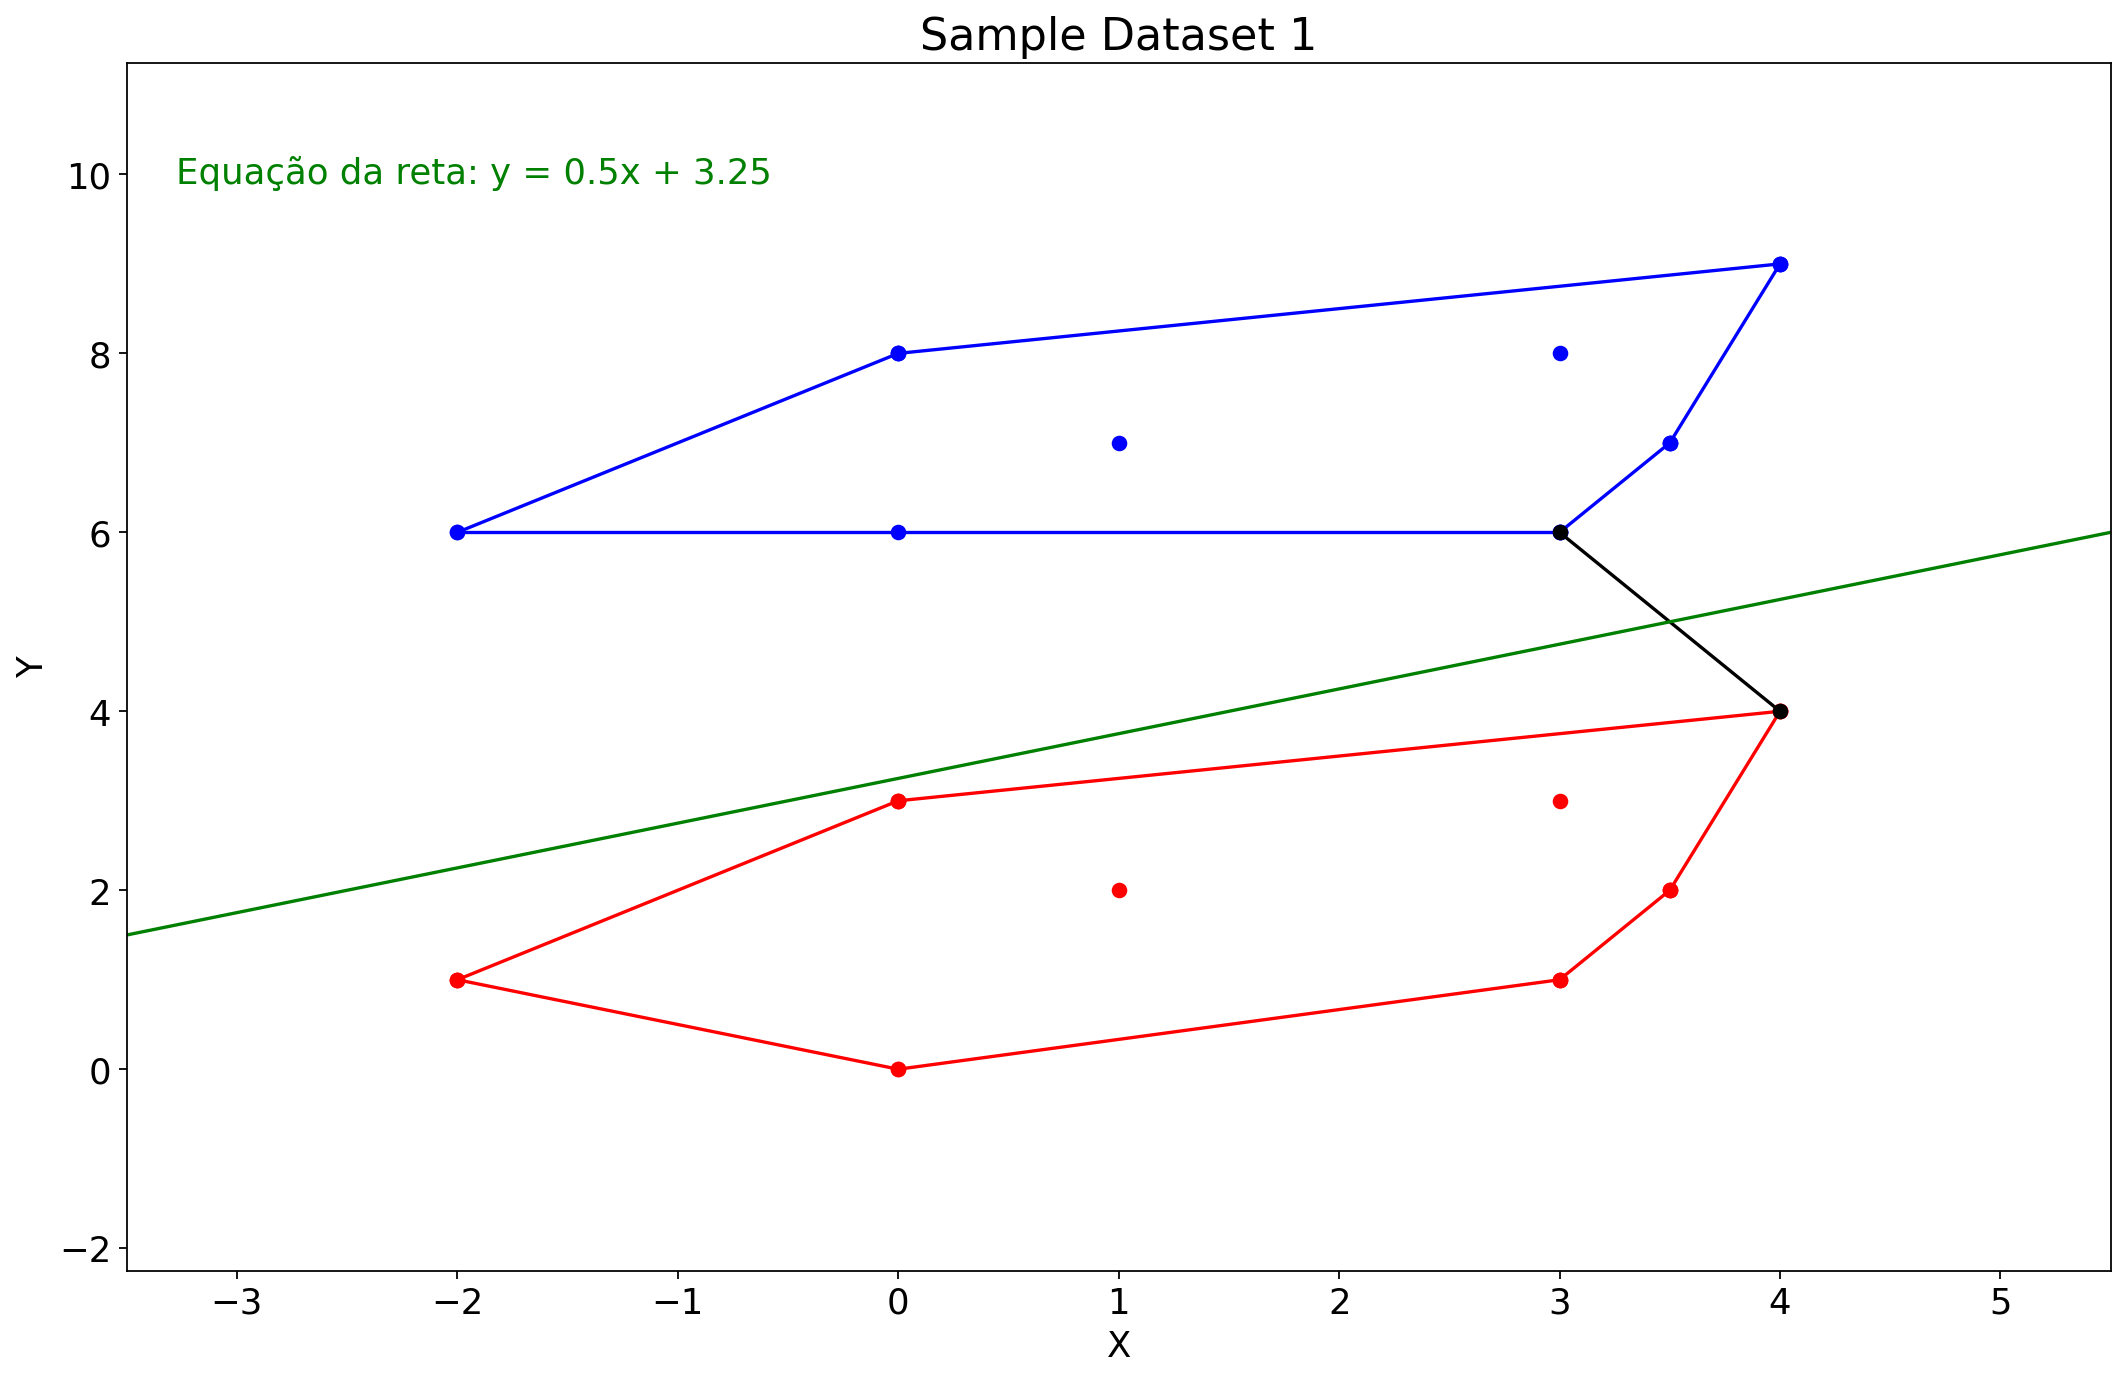

In [89]:
samplePoints1 = {  
    'X': [0, 1, 4, 0, 3, 3, 3.5, -2, 0, 1, 4, 0, 3, 3, 3.5, -2], 
    'Y': [3, 2, 4, 0, 1, 3, 2, 1, 8, 7, 9, 6, 6, 8, 7, 6],
    'Class': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
}

sample1 = pd.DataFrame(samplePoints1)

findAndPlotModel(sample1, "Sample Dataset 1")

In [90]:
evaluateModel(sample1)

As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.
Avaliação do modelo:
Fold: 1
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 2
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 3
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 4
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 5
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0


### Experimento Banana
Um conjunto de dados artificial no qual as instâncias pertencem a vários clusters que classificam uma banana de acordo com seu formato.

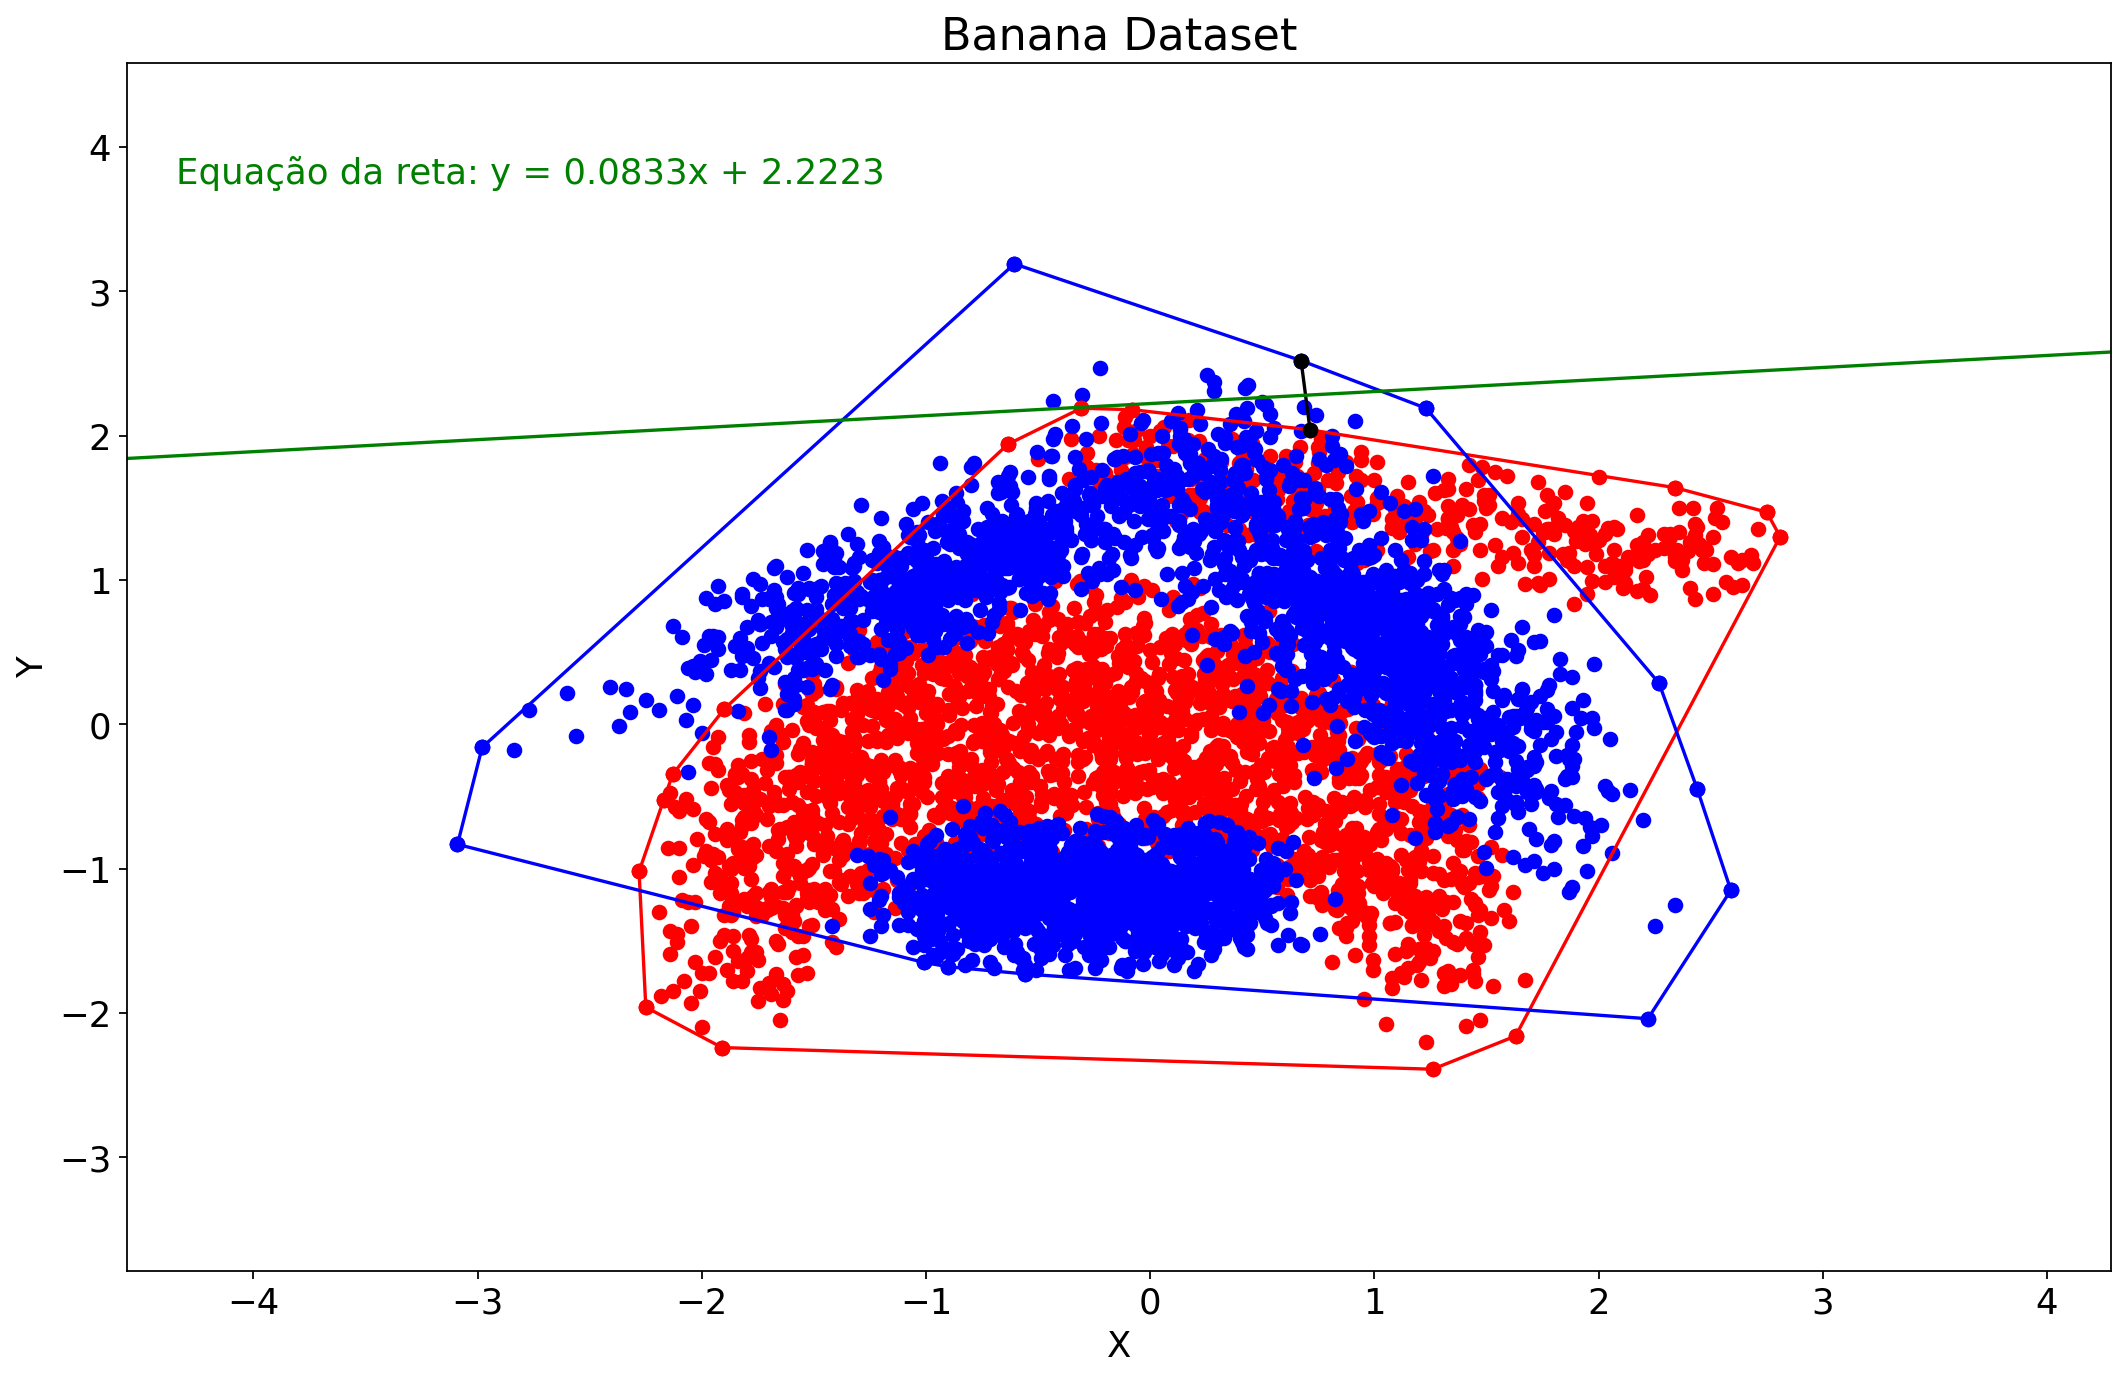

In [91]:
banana = readDatFile('datFiles/banana.dat', ',')

banana = banana.replace({'Class': {-1.0: 0, 1.0: 1}})

findAndPlotModel(banana, "Banana Dataset")


In [92]:
evaluateModel(banana)

As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.


### Experimento Iris
O dataset em questão se refere ao tipo de Iris de uma planta, cada iris é uma classe. Para esse experimento escolhemos as classes Iris-Setosa e Iris-Versicolor, as duas classes são linearmente separáveis e a reta de separação tem a tragetória ilustrada na imagem abaixo.

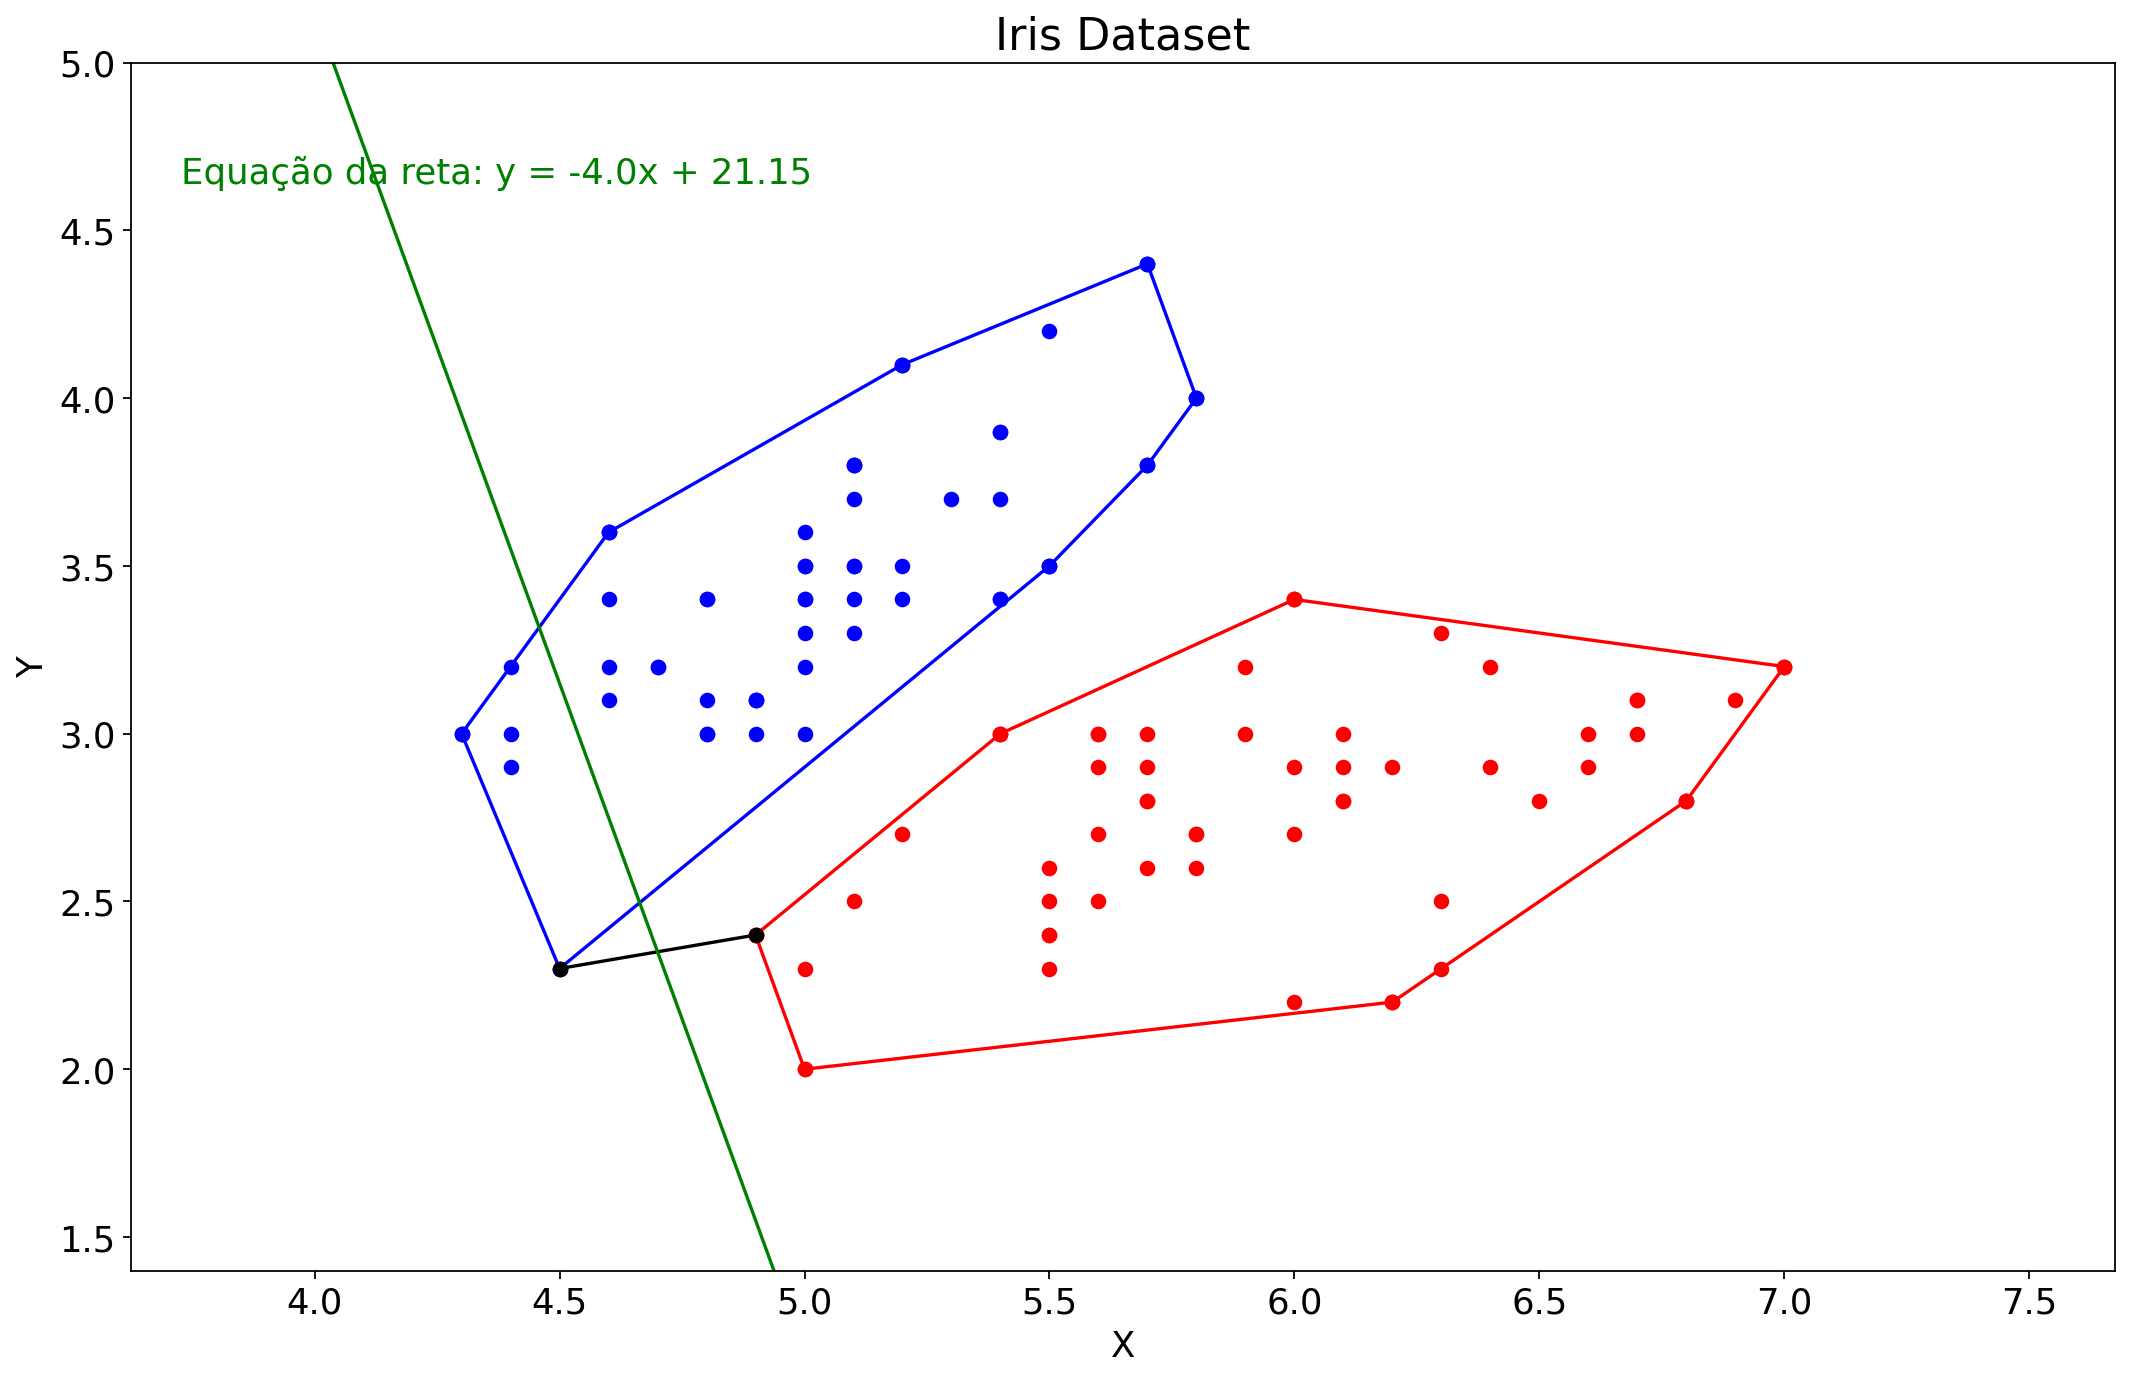

In [93]:
iris = readDatFile('datFiles/iris.dat', ', ')

iris = iris.replace({'Class': {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}})
iris = iris[iris['Class'] != 2]
iris = pd.DataFrame({'X': iris['SepalLength'], 'Y': iris['SepalWidth'], 'Class': iris['Class']})

findAndPlotModel(iris, "Iris Dataset")

In [94]:
evaluateModel(iris)

As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.
Avaliação do modelo:
Fold: 1
	Precisão: 0.0
	Revocação: 0.0
	F-Score: 0.0
Fold: 2
	Precisão: 0.5263157894736842
	Revocação: 1.0
	F-Score: 0.6896551724137931
Fold: 3
	Precisão: 0.5
	Revocação: 1.0
	F-Score: 0.6666666666666666
Fold: 4
	Precisão: 0.0
	Revocação: 0.0
	F-Score: 0.0
Fold: 5
	Precisão: 0.5263157894736842
	Revocação: 1.0
	F-Score: 0.6896551724137931


### Experimento Anel
Este é um problema de classificação de 20 dimensões e 2 classes. Utlizamos os atributos A12 e A19 para projetar as envoltórias e é possível perceber que o modelo não é linearmente separável, entrando em um caso interessante: uma envoltória está completamente dentro da outra.


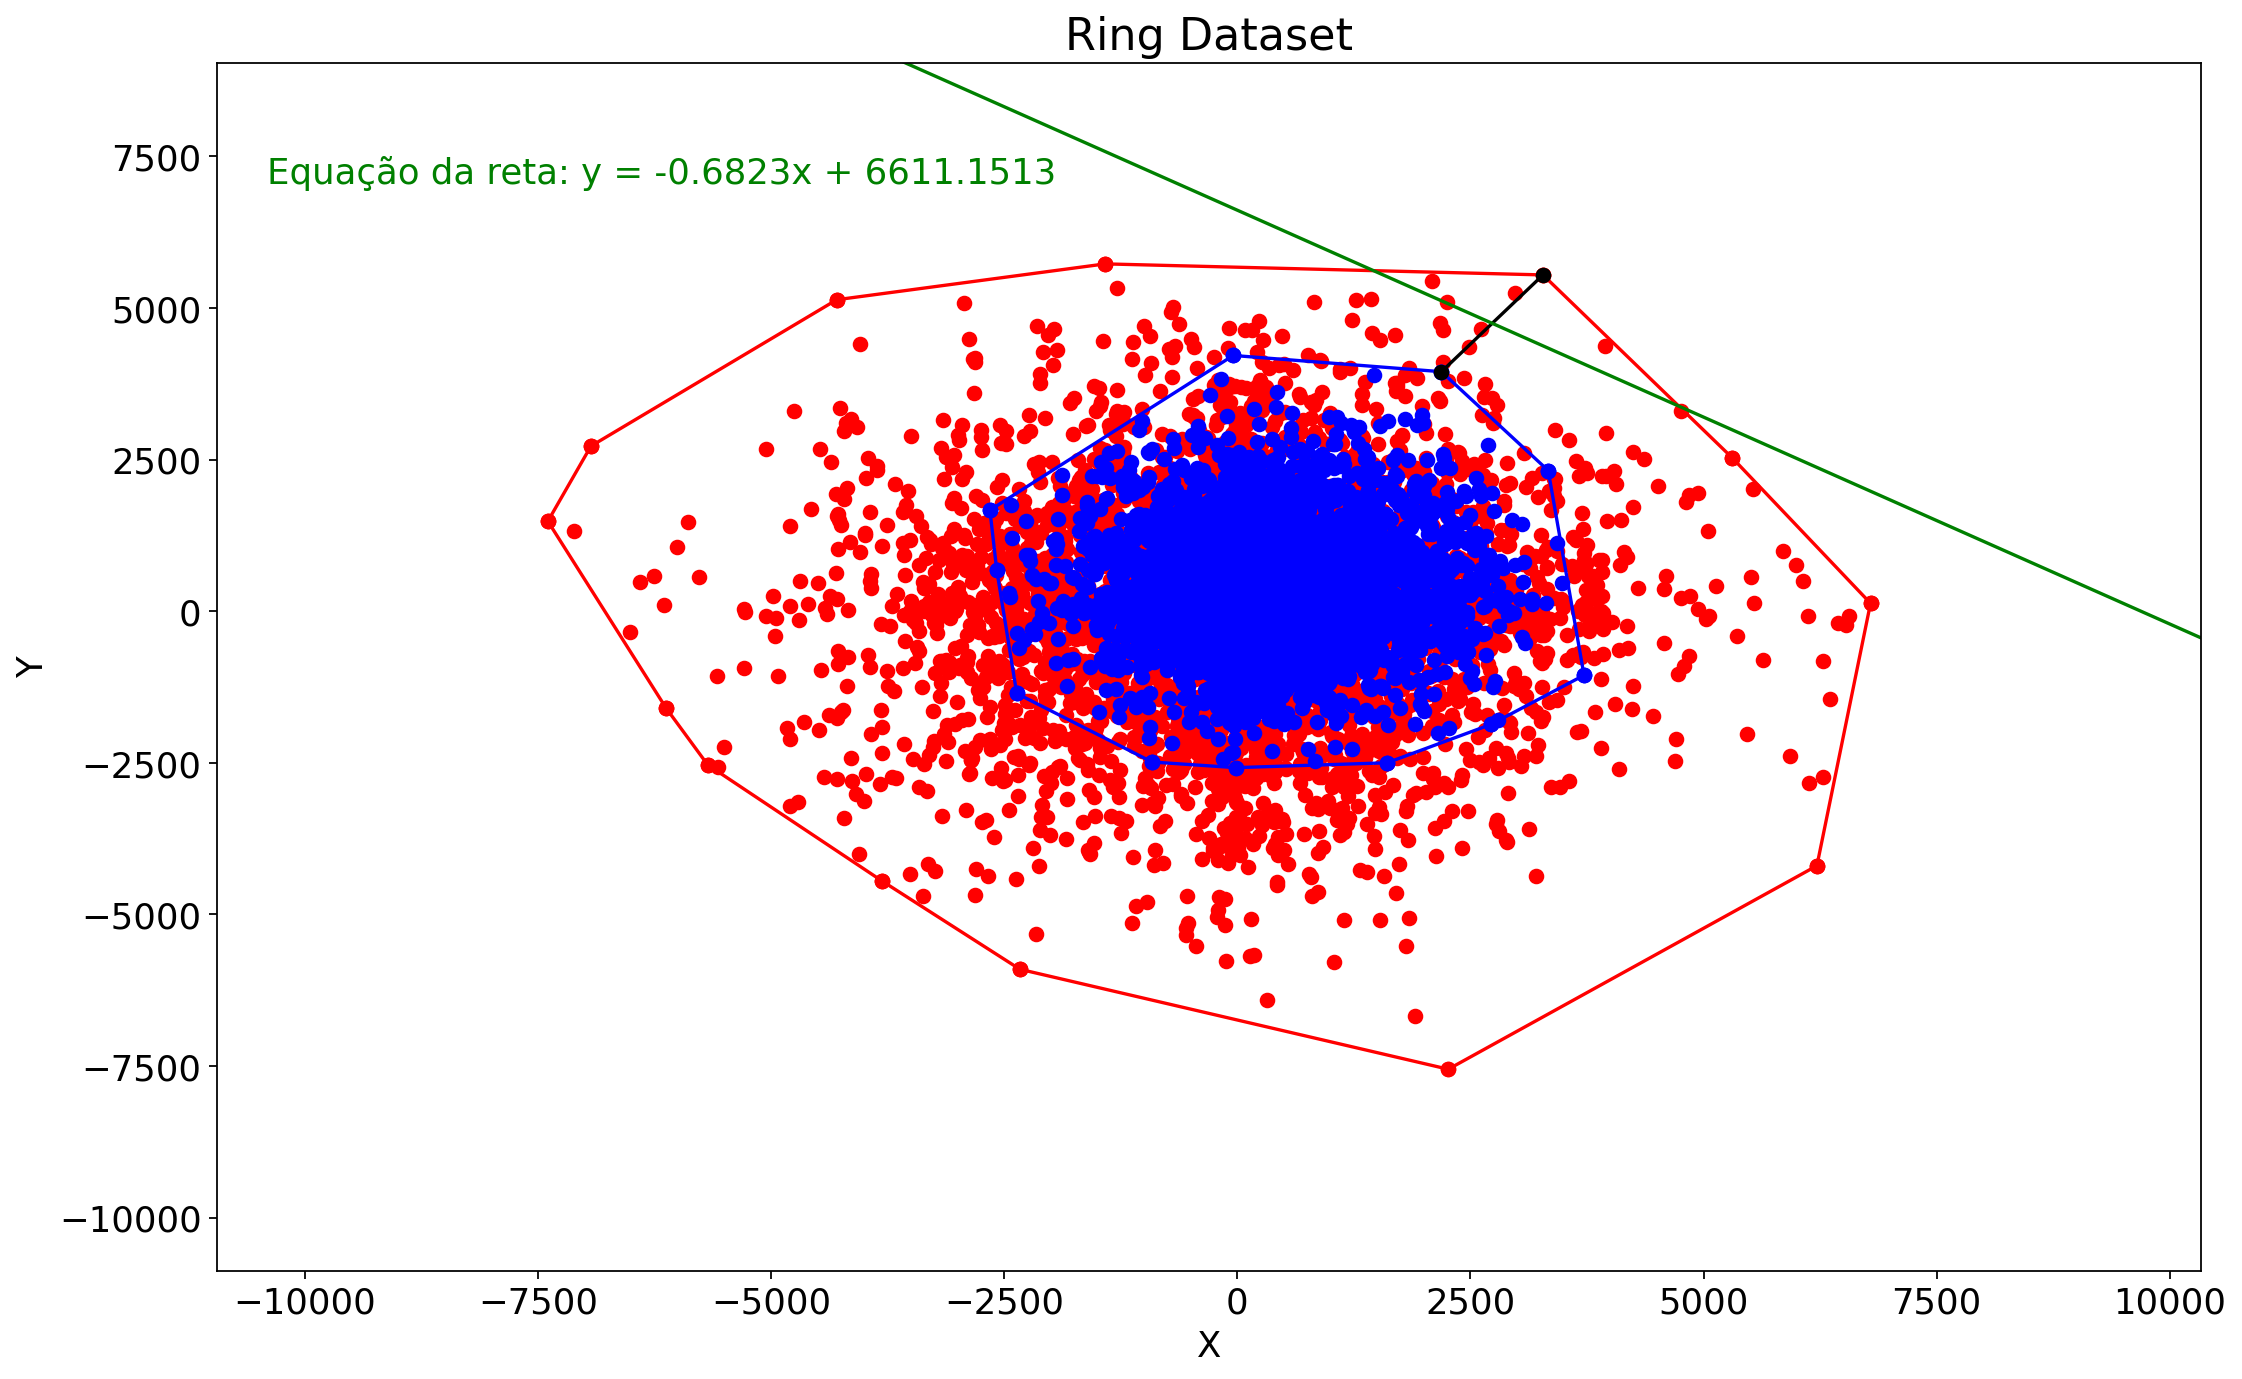

In [95]:
ring = readDatFile('datFiles/ring.dat', ', ')

ring = pd.DataFrame({'X': ring['A12'], 'Y': ring['A19'], 'Class': ring['Class']})

findAndPlotModel(ring, "Ring Dataset")

In [96]:
evaluateModel(ring)

As envoltórias convexas se sobrepõem, portanto, os conjuntos não são linearmente separáveis.


### Experimento Movement Libras
Esse data set contém 15 classes de 24 instâncias cada. Cada uma das classes é referente a um movimento da linguagem Brasileira de Sinais (LIBRAS).

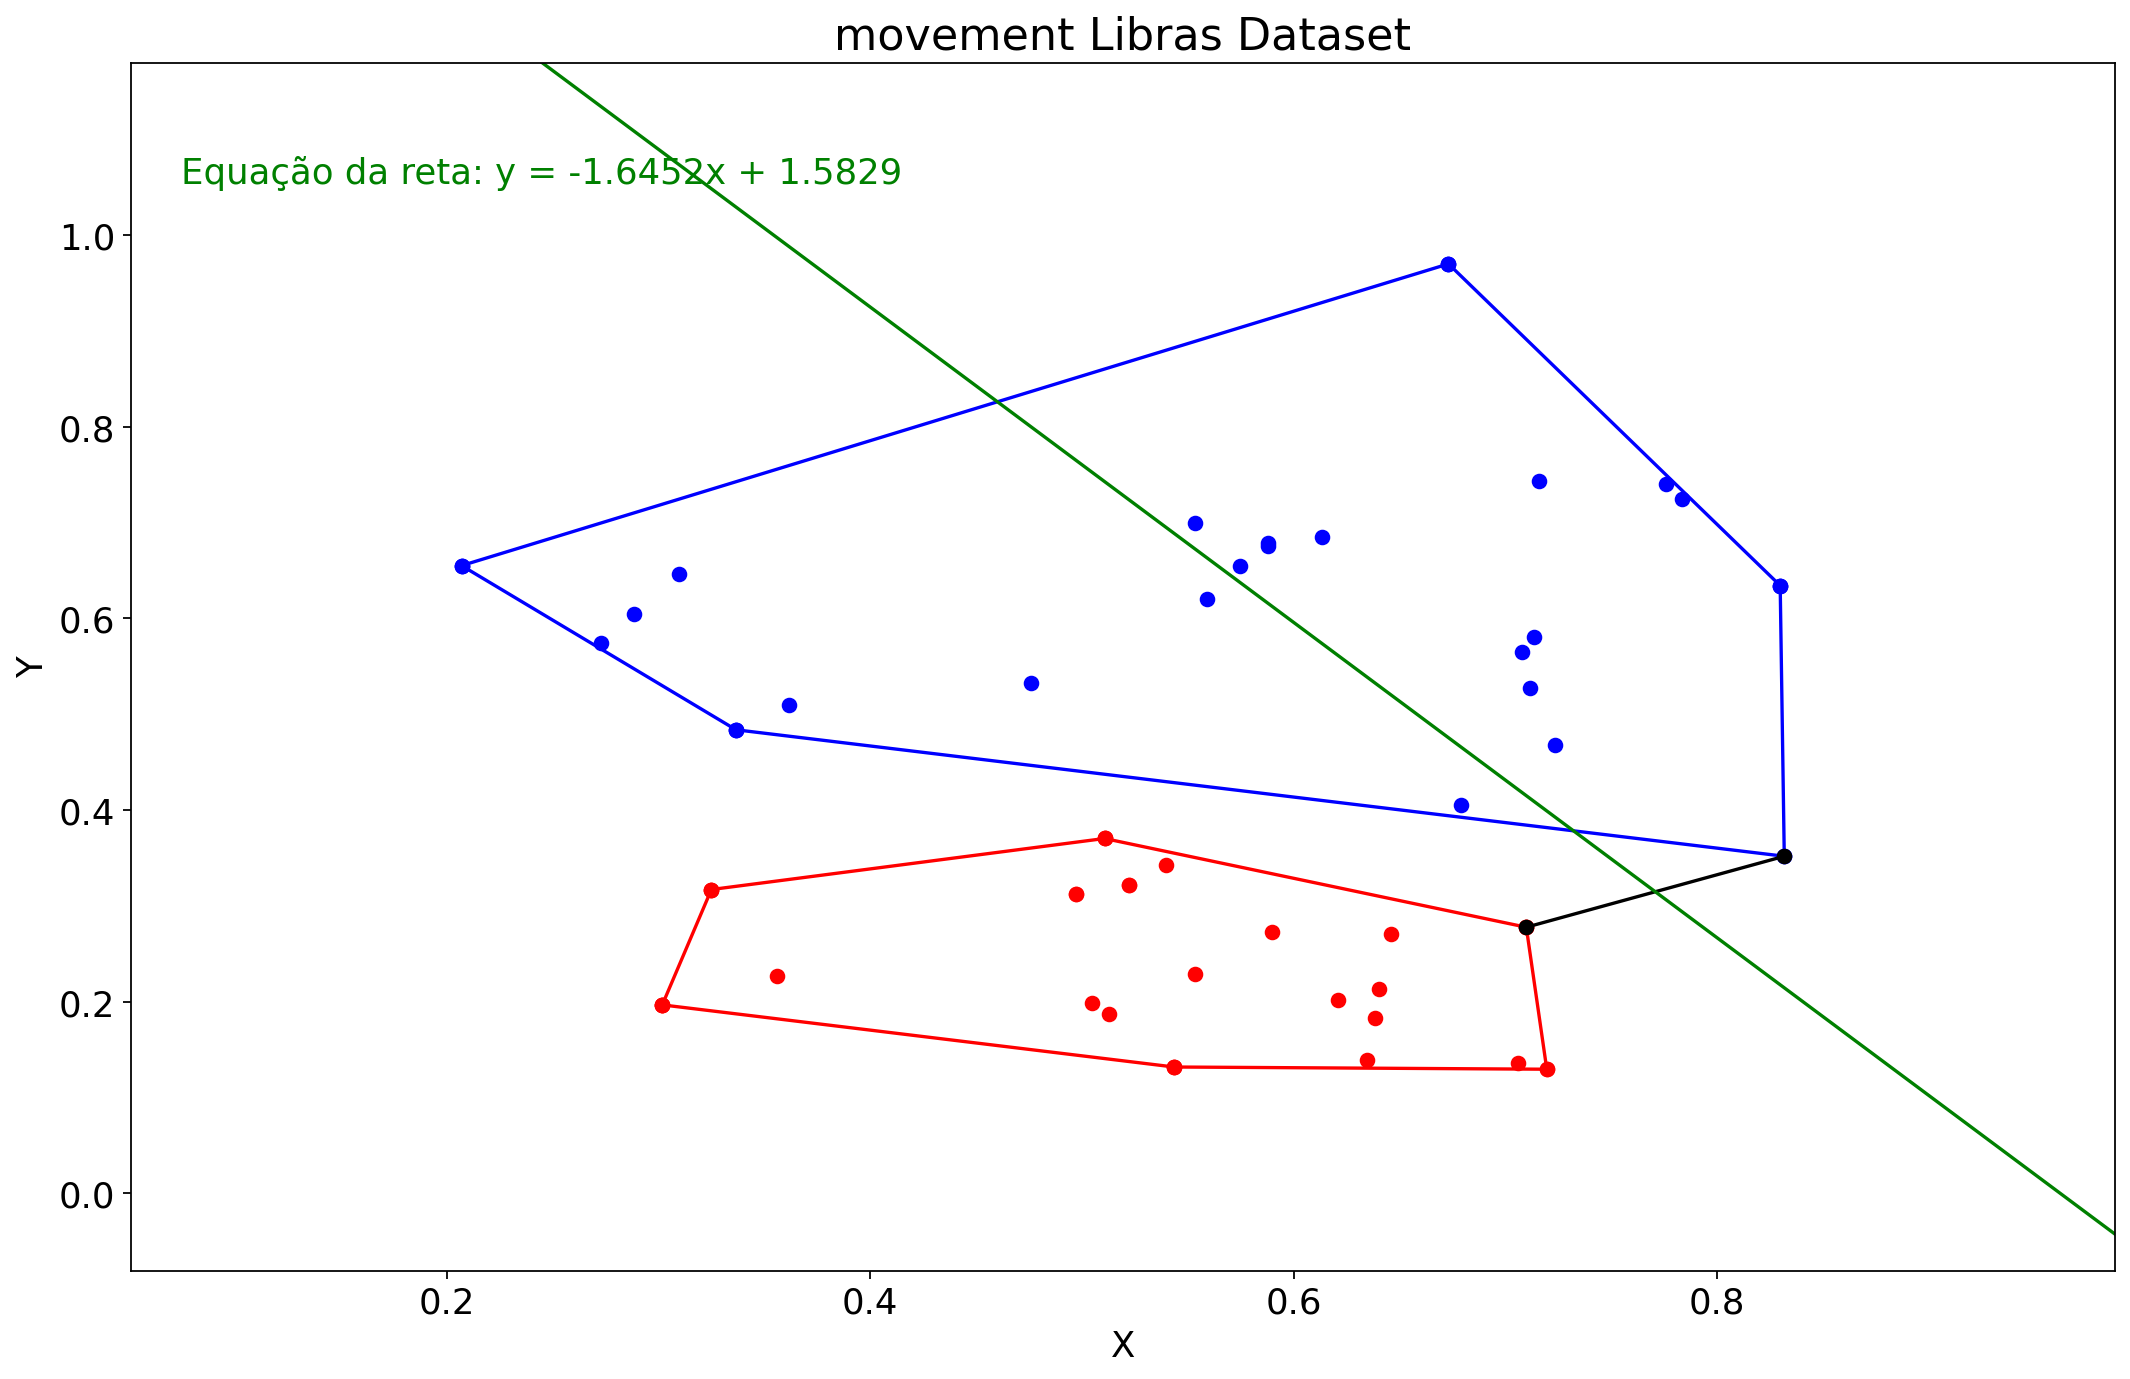

In [97]:
movementLibras = readDatFile('datFiles/movement_libras.dat', ',')

movementLibras = movementLibras.replace({'Class': {13: 0, 1: 1}})
movementLibras = movementLibras.query("Class == 0 or Class == 1")
movementLibras = pd.DataFrame({'X': movementLibras['5st_coordinate_abcissa'], 'Y': movementLibras['39st_coordinate_ordinate'], 'Class': movementLibras['Class']})
movementLibras = movementLibras.drop(labels=293, axis=0)

findAndPlotModel(movementLibras, "movement Libras Dataset")


In [98]:
evaluateModel(movementLibras)

As envoltórias convexas se sobrepõem, portanto, os conjuntos não são linearmente separáveis.


### Experimento Texture
O objetivo nesse data set é distinguir entre 11 diferentes texturas. Utilizamos as classes 12 e 9 para trças as envoltórias e os atributos A13 e A18

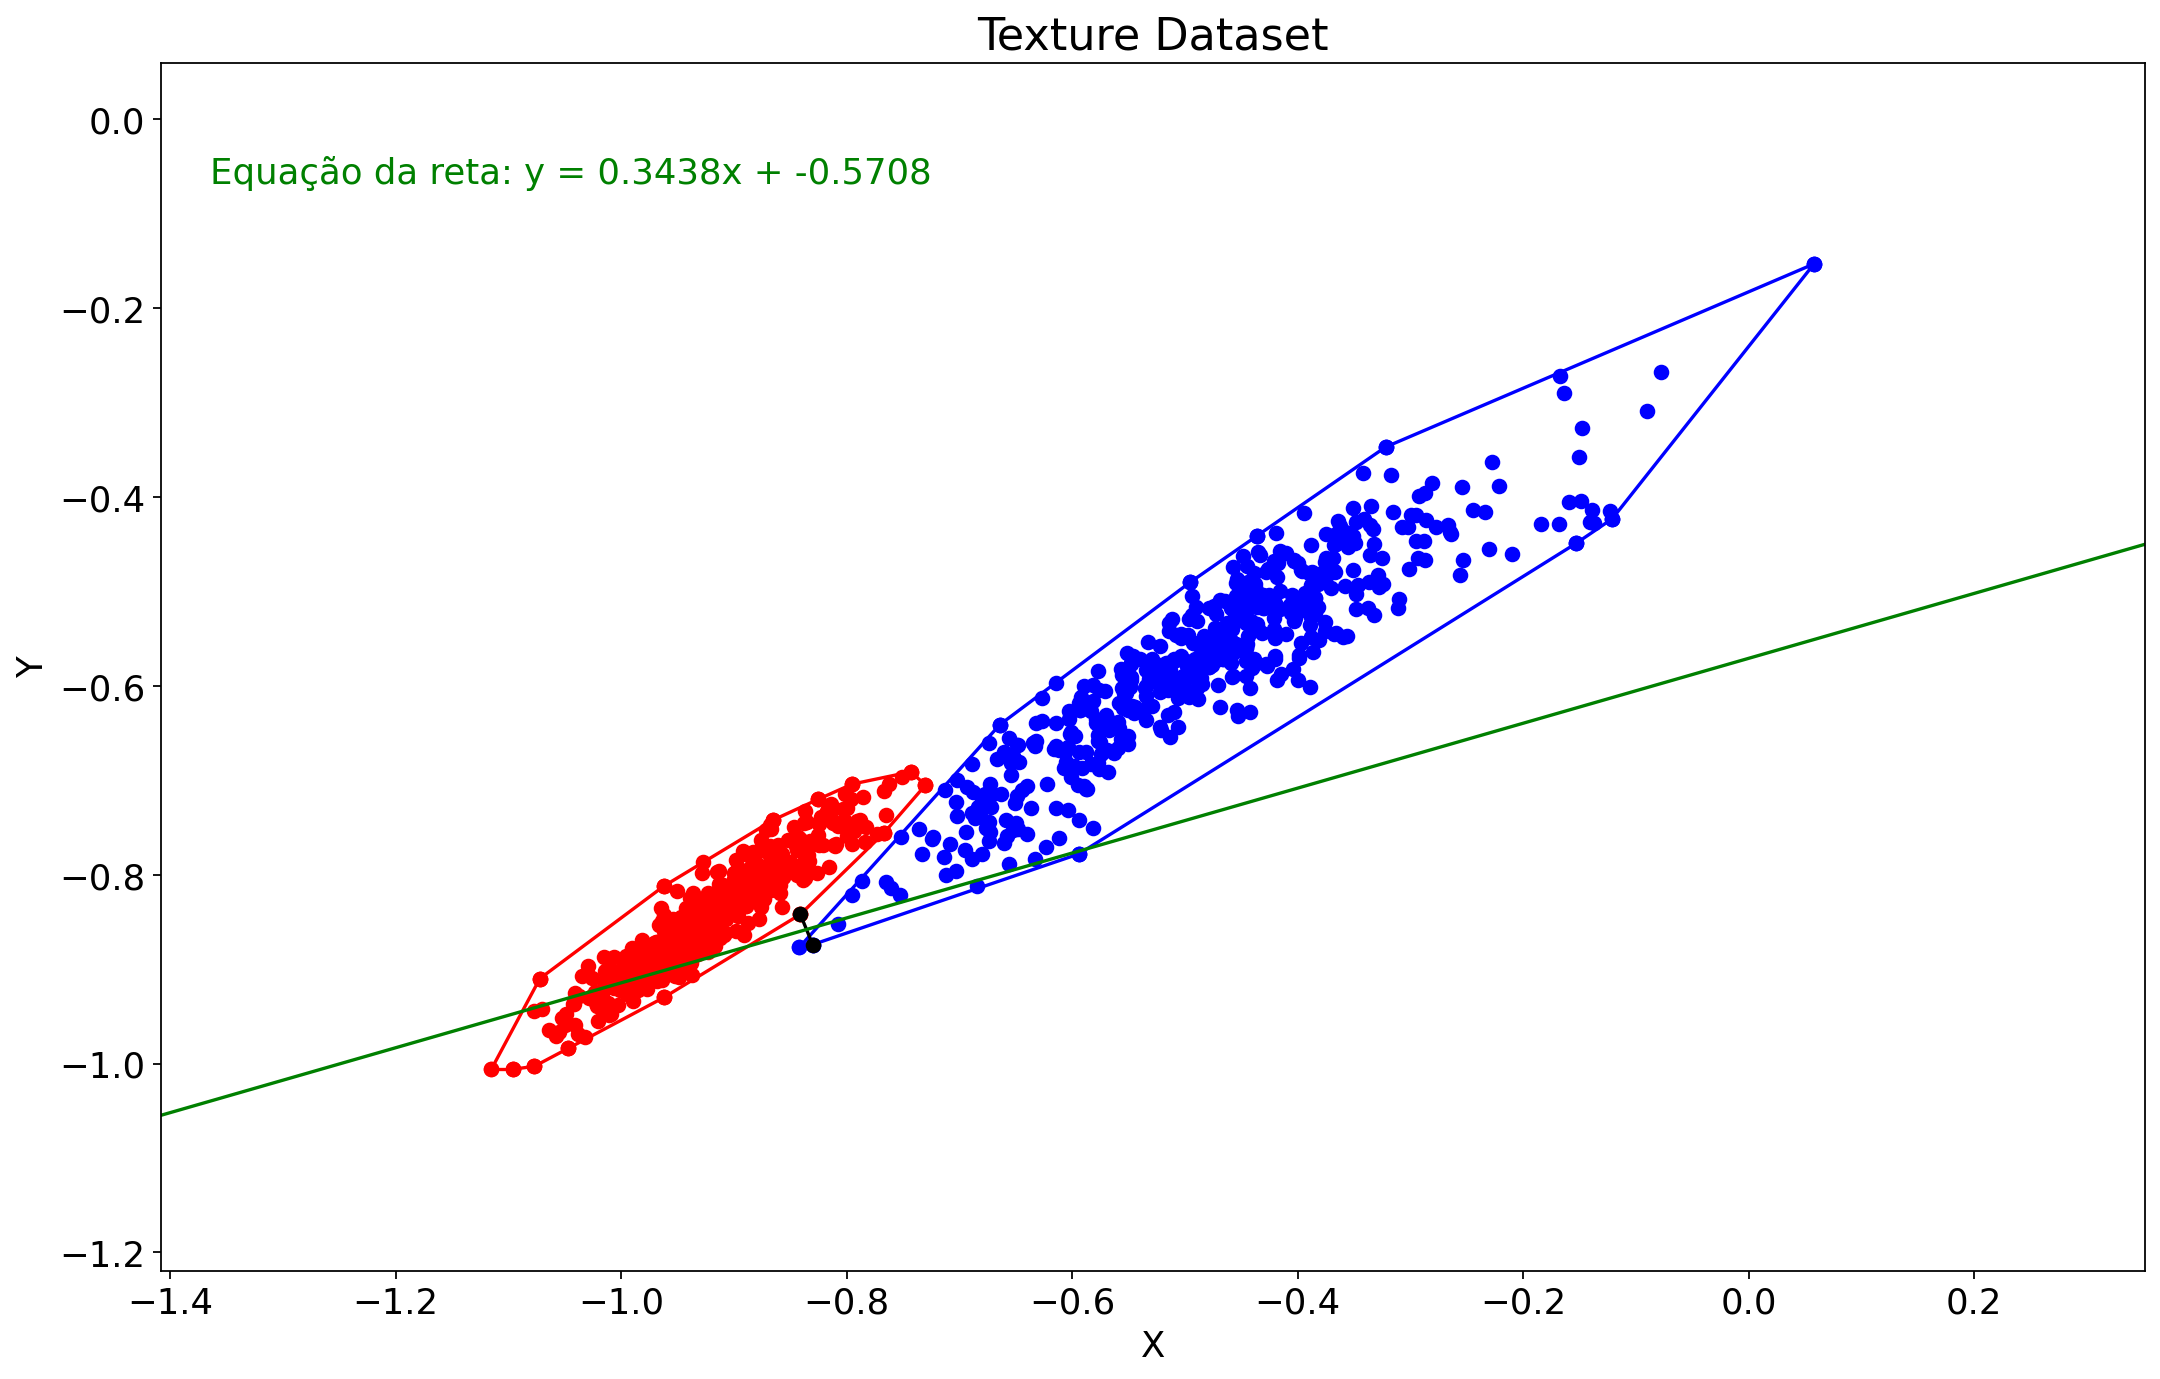

In [99]:
texture = readDatFile('datFiles/texture.dat', ',')

texture = texture.replace({'Class': {12: 0, 9: 1}})
texture = texture.query("Class == 0 or Class == 1")
texture = pd.DataFrame({'X': texture['A13'], 'Y': texture['A18'], 'Class': texture['Class']})

texture = texture.drop(labels=1616, axis='index')

findAndPlotModel(texture, "Texture Dataset")


In [100]:
evaluateModel(texture)

As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.
Avaliação do modelo:
Fold: 1
	Precisão: 0.009900990099009901
	Revocação: 0.01
	F-Score: 0.009950248756218905
Fold: 2
	Precisão: 1.0
	Revocação: 0.9
	F-Score: 0.9473684210526316
Fold: 3
	Precisão: 0.5294117647058824
	Revocação: 0.99
	F-Score: 0.6898954703832753
Fold: 4
	Precisão: 0.673469387755102
	Revocação: 0.99
	F-Score: 0.8016194331983807
Fold: 5
	Precisão: 0.5185185185185185
	Revocação: 0.98989898989899
	F-Score: 0.6805555555555556


### Experimento Segment
Este banco de dados contém instâncias extraídas aleatoriamente de um banco de dados de 7 imagens externas (classes). As imagens foram segmentadas manualmente para criar uma classificação para cada pixel.

Utilizamos os atriutos Rawblue-mean e Exred-mean e as classes 1 e 2 para traçar as envoltórias

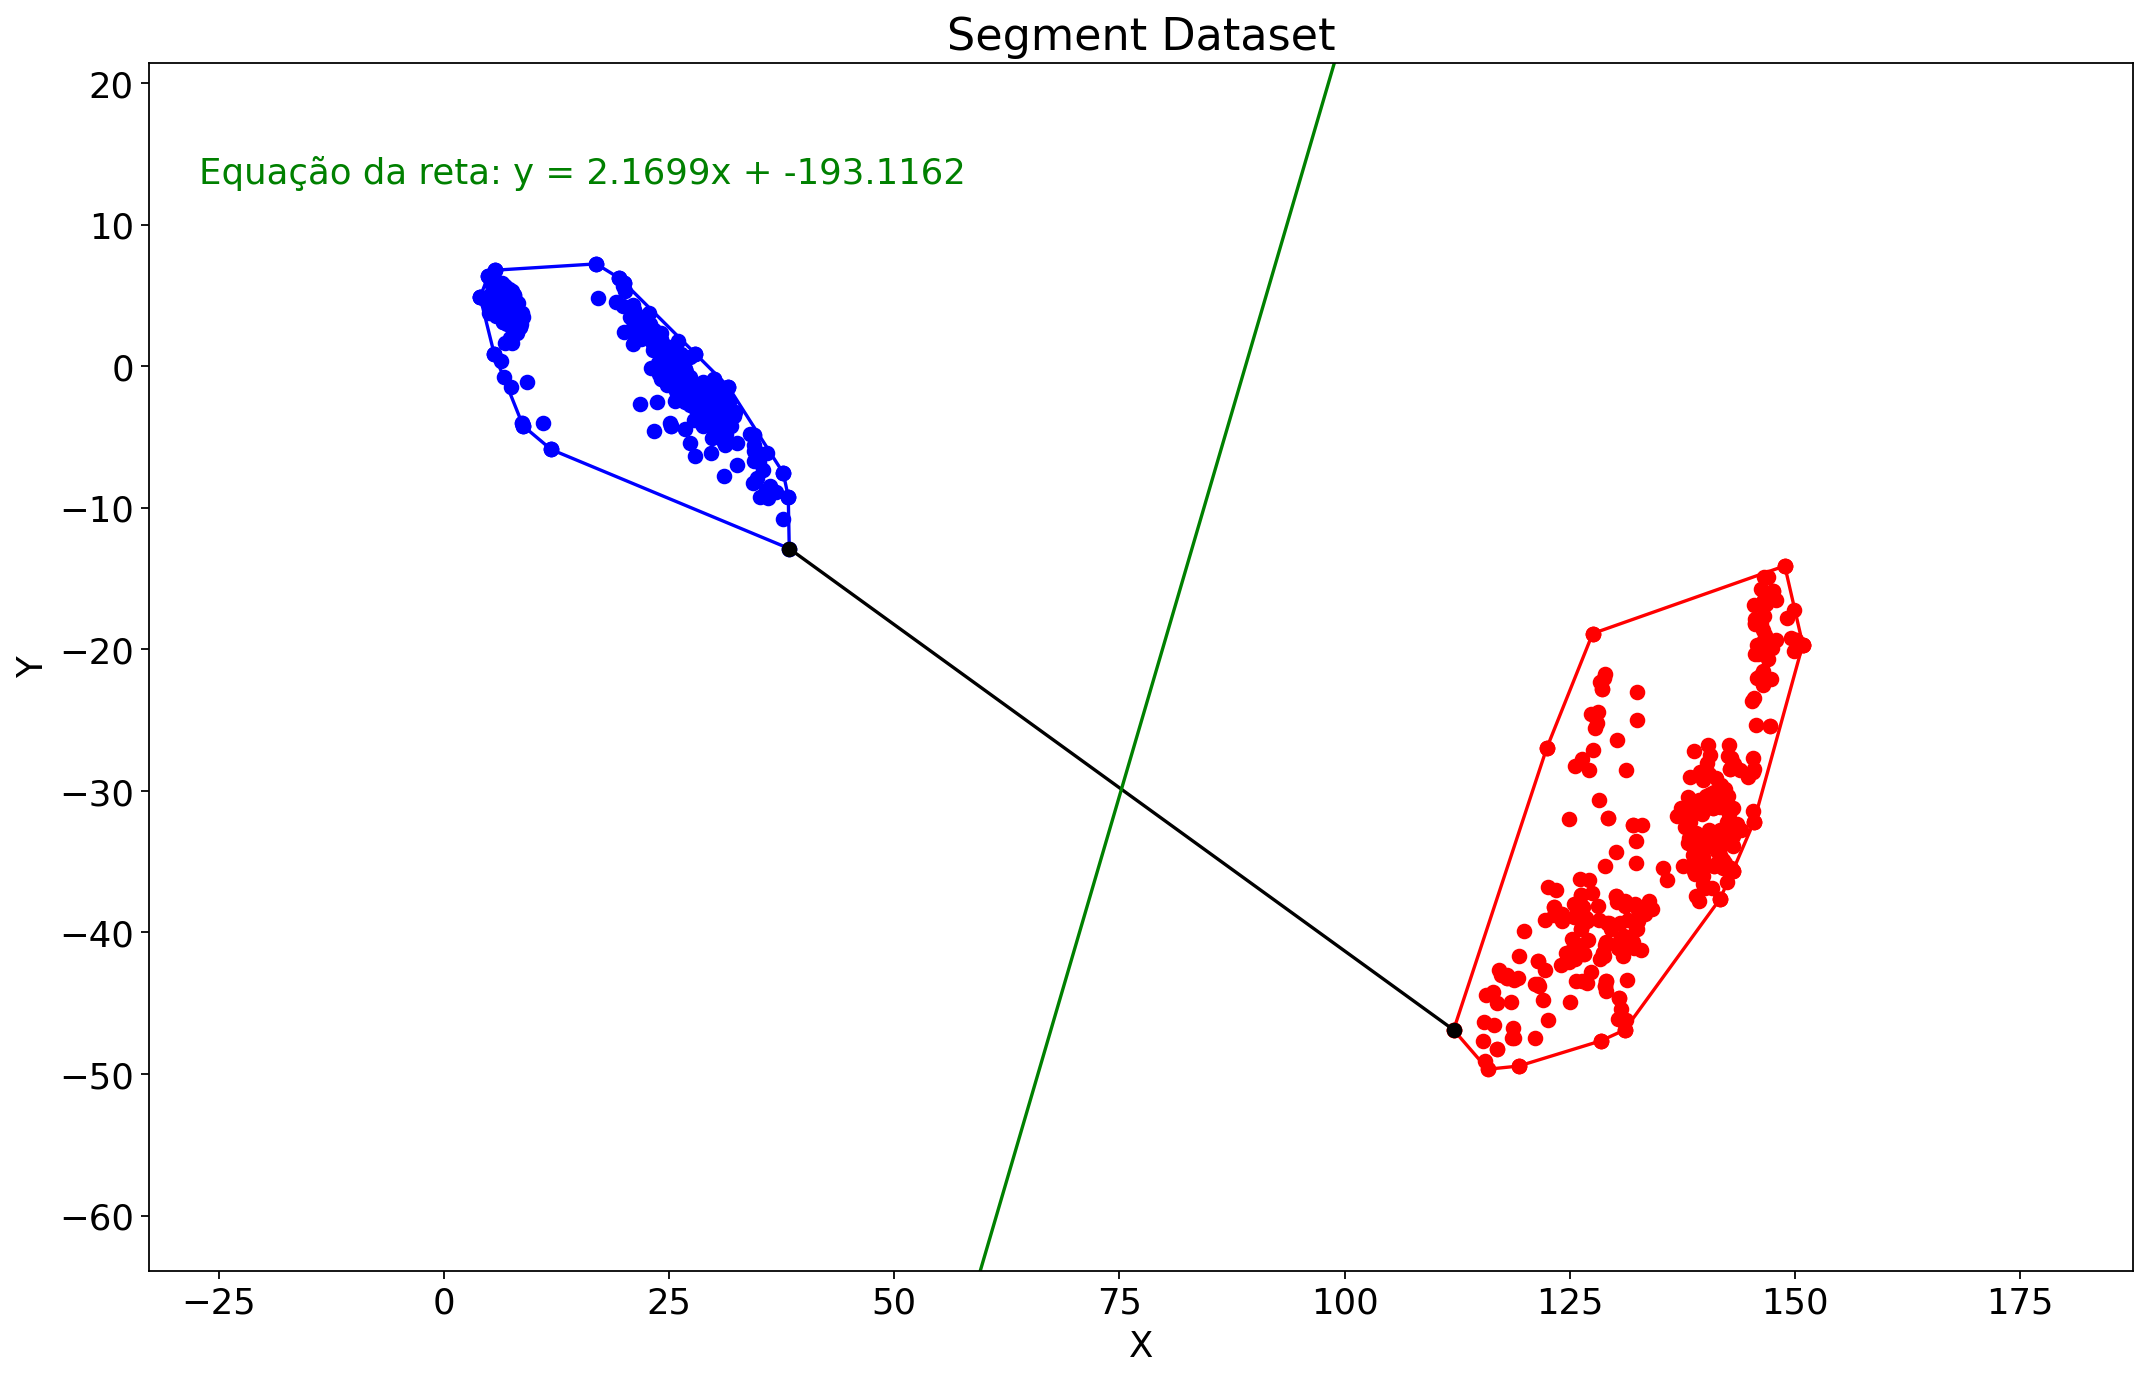

In [101]:
_Segment = readDatFile('datFiles/segment.dat', ', ')

_Segment = _Segment.replace({'Class': {1: 0, 2: 1}})
_Segment = _Segment.query("Class == 0 or Class == 1")
_Segment = pd.DataFrame({'X': _Segment['Rawblue-mean'], 'Y': _Segment['Exred-mean'], 'Class': _Segment['Class']})

findAndPlotModel(_Segment, "Segment Dataset")

In [102]:
evaluateModel(_Segment)

As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.
Avaliação do modelo:
Fold: 1
	Precisão: 0.0
	Revocação: 0.0
	F-Score: 0.0
Fold: 2
	Precisão: 0.0
	Revocação: 0.0
	F-Score: 0.0
Fold: 3
	Precisão: 0.0
	Revocação: 0.0
	F-Score: 0.0
Fold: 4
	Precisão: 0.0
	Revocação: 0.0
	F-Score: 0.0
Fold: 5
	Precisão: 0.0
	Revocação: 0.0
	F-Score: 0.0


### Experimento Shuttle
O dataset em questão tem como objetivo oferecer dados para a decisão de em quais casos pousar uma nave espacial através do piloto automático é mais vantajoso do que através do controle manual. O dataset tem nove atributos dos quais dois foram usados em nossos experimentos e as classes dois (Fpv close) e seis (Bpv close) foram as escolhidas para dividir o experimento em dois grupos. Nesse caso os dois grupos possuem dados linearmente separáveis e a reta de separação tem a tragedória ilustrada na imagem abaixo.

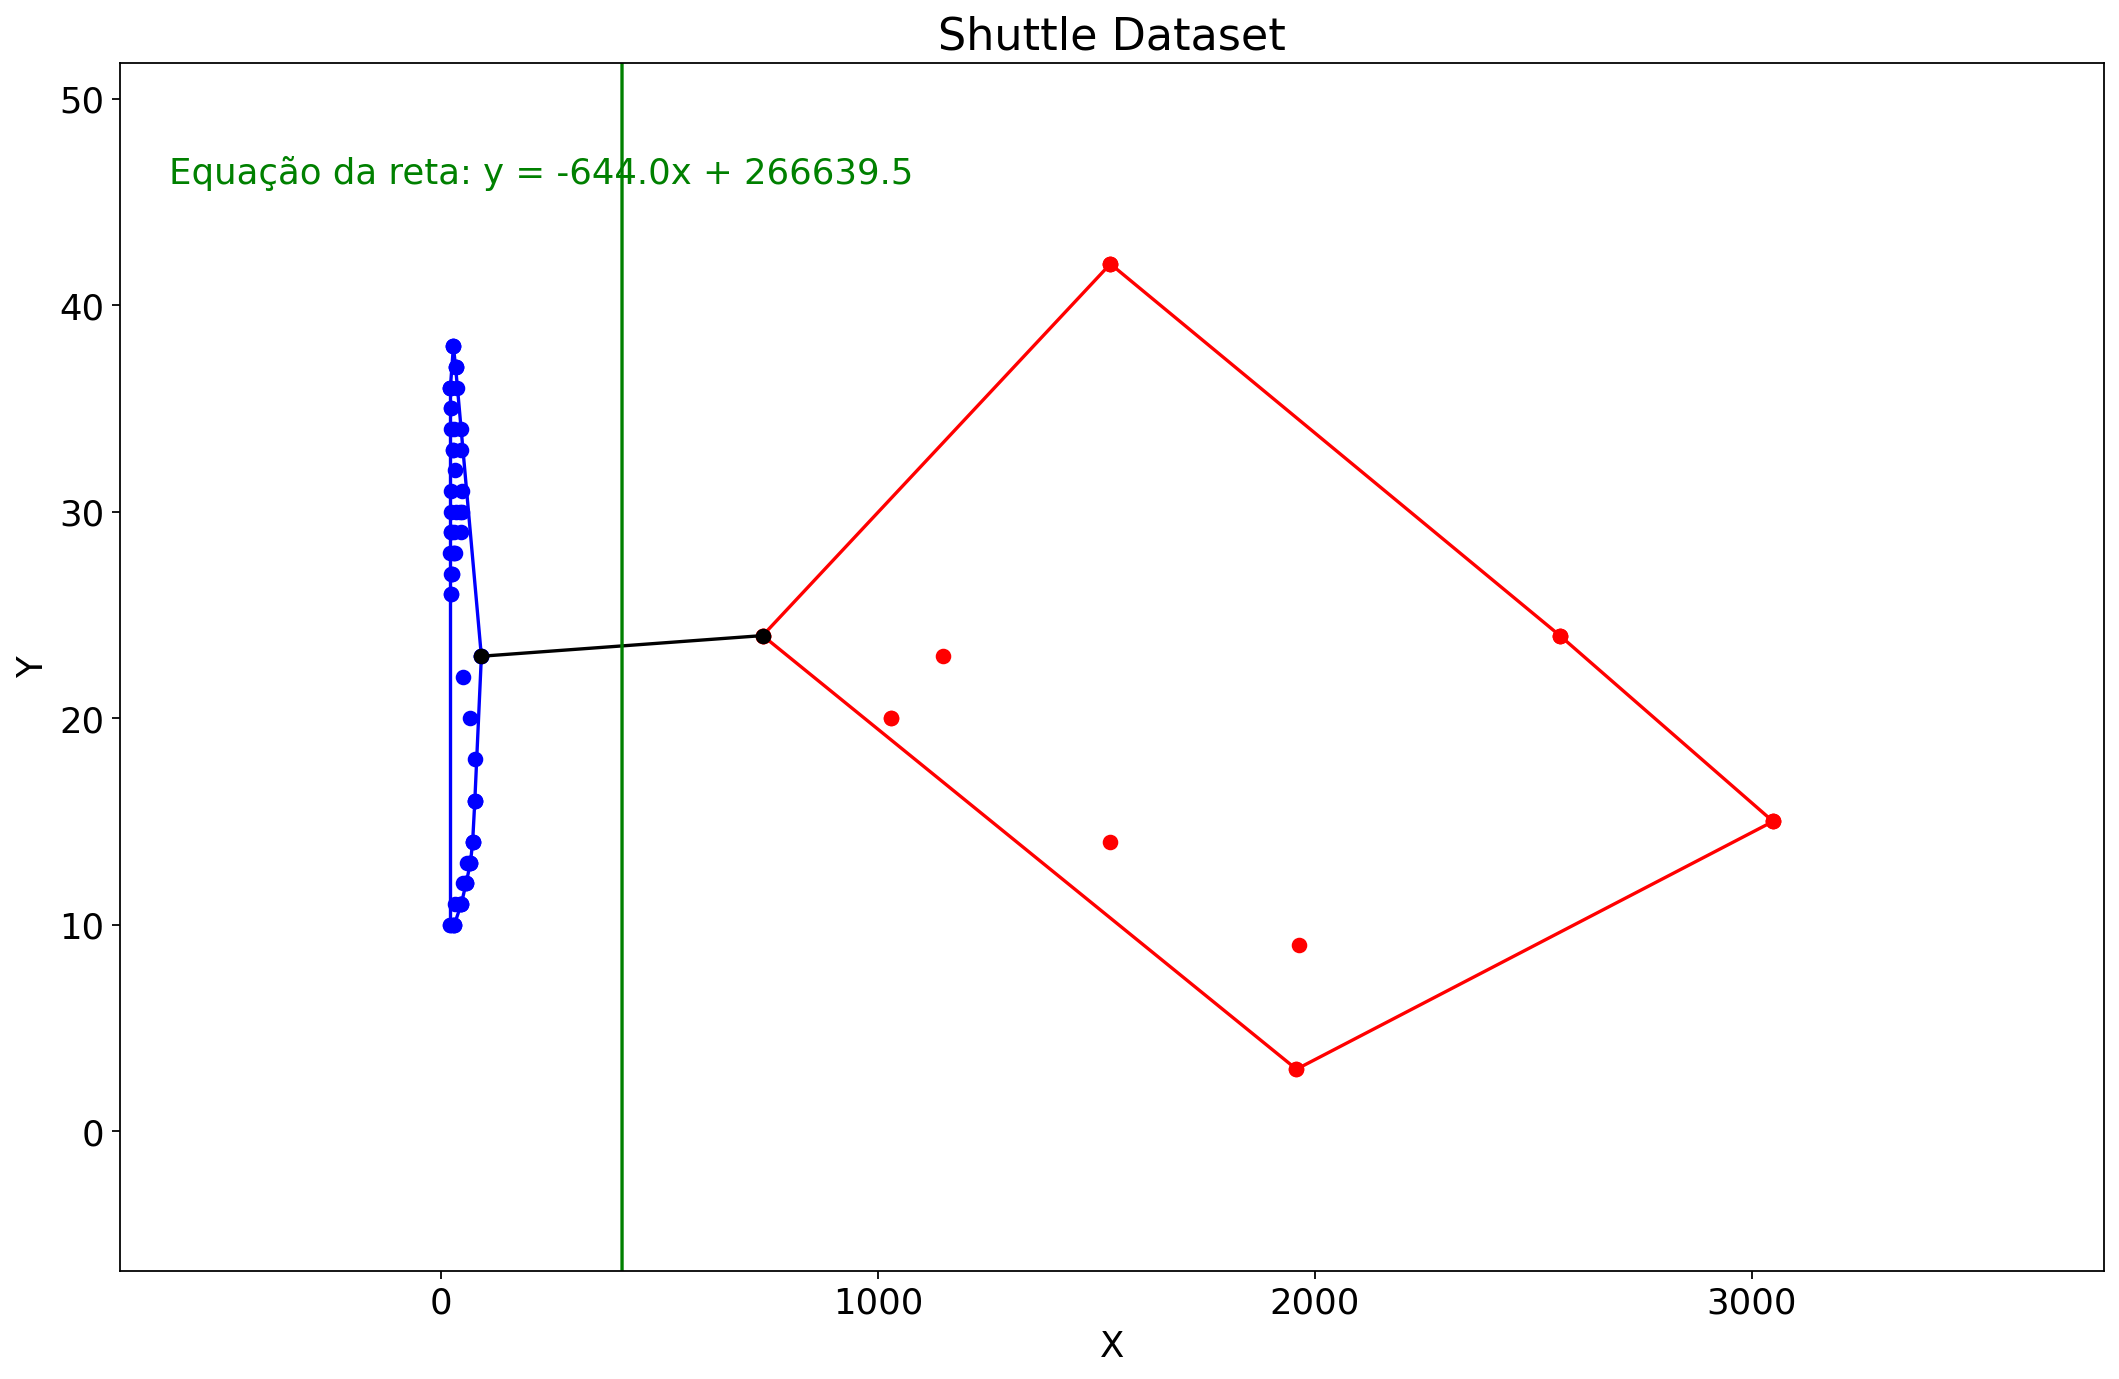

In [103]:
shuttle = readDatFile('datFiles/shuttle.dat',',')

shuttle = shuttle.replace({'Class':{2:0,1:10,6:1}})
shuttle = shuttle.query("Class == 0 or Class == 1")
shuttle = pd.DataFrame({'X':shuttle['A2'],'Y':shuttle['A7'],'Class':shuttle['Class']})

findAndPlotModel(shuttle,"Shuttle Dataset")

In [109]:
evaluateModel(shuttle)

As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.
Avaliação do modelo:
Fold: 1
	Precisão: 0.0
	Revocação: 0.0
	F-Score: 0.0
Fold: 2
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 3
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 4
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0
Fold: 5
	Precisão: 1.0
	Revocação: 1.0
	F-Score: 1.0


### Experimento Page Blocks
O dataset em questão contém layouts de blocos de página de um documento que foram detectados em um processo de segmentação. O objetivo do dataset é determinar o tipo de bloco através dos dez parâmetros usados. São cinco blocos que compôem as classes desse experimento e foram escolhidos o número três (Gráfico) e o número quatro (Linha Vertical). É possível perceber que os dados, para as duas classes escolhidas, são linearmente separáveis e a reta de separação tem a tragetória ilustrada na imagem abaixo.

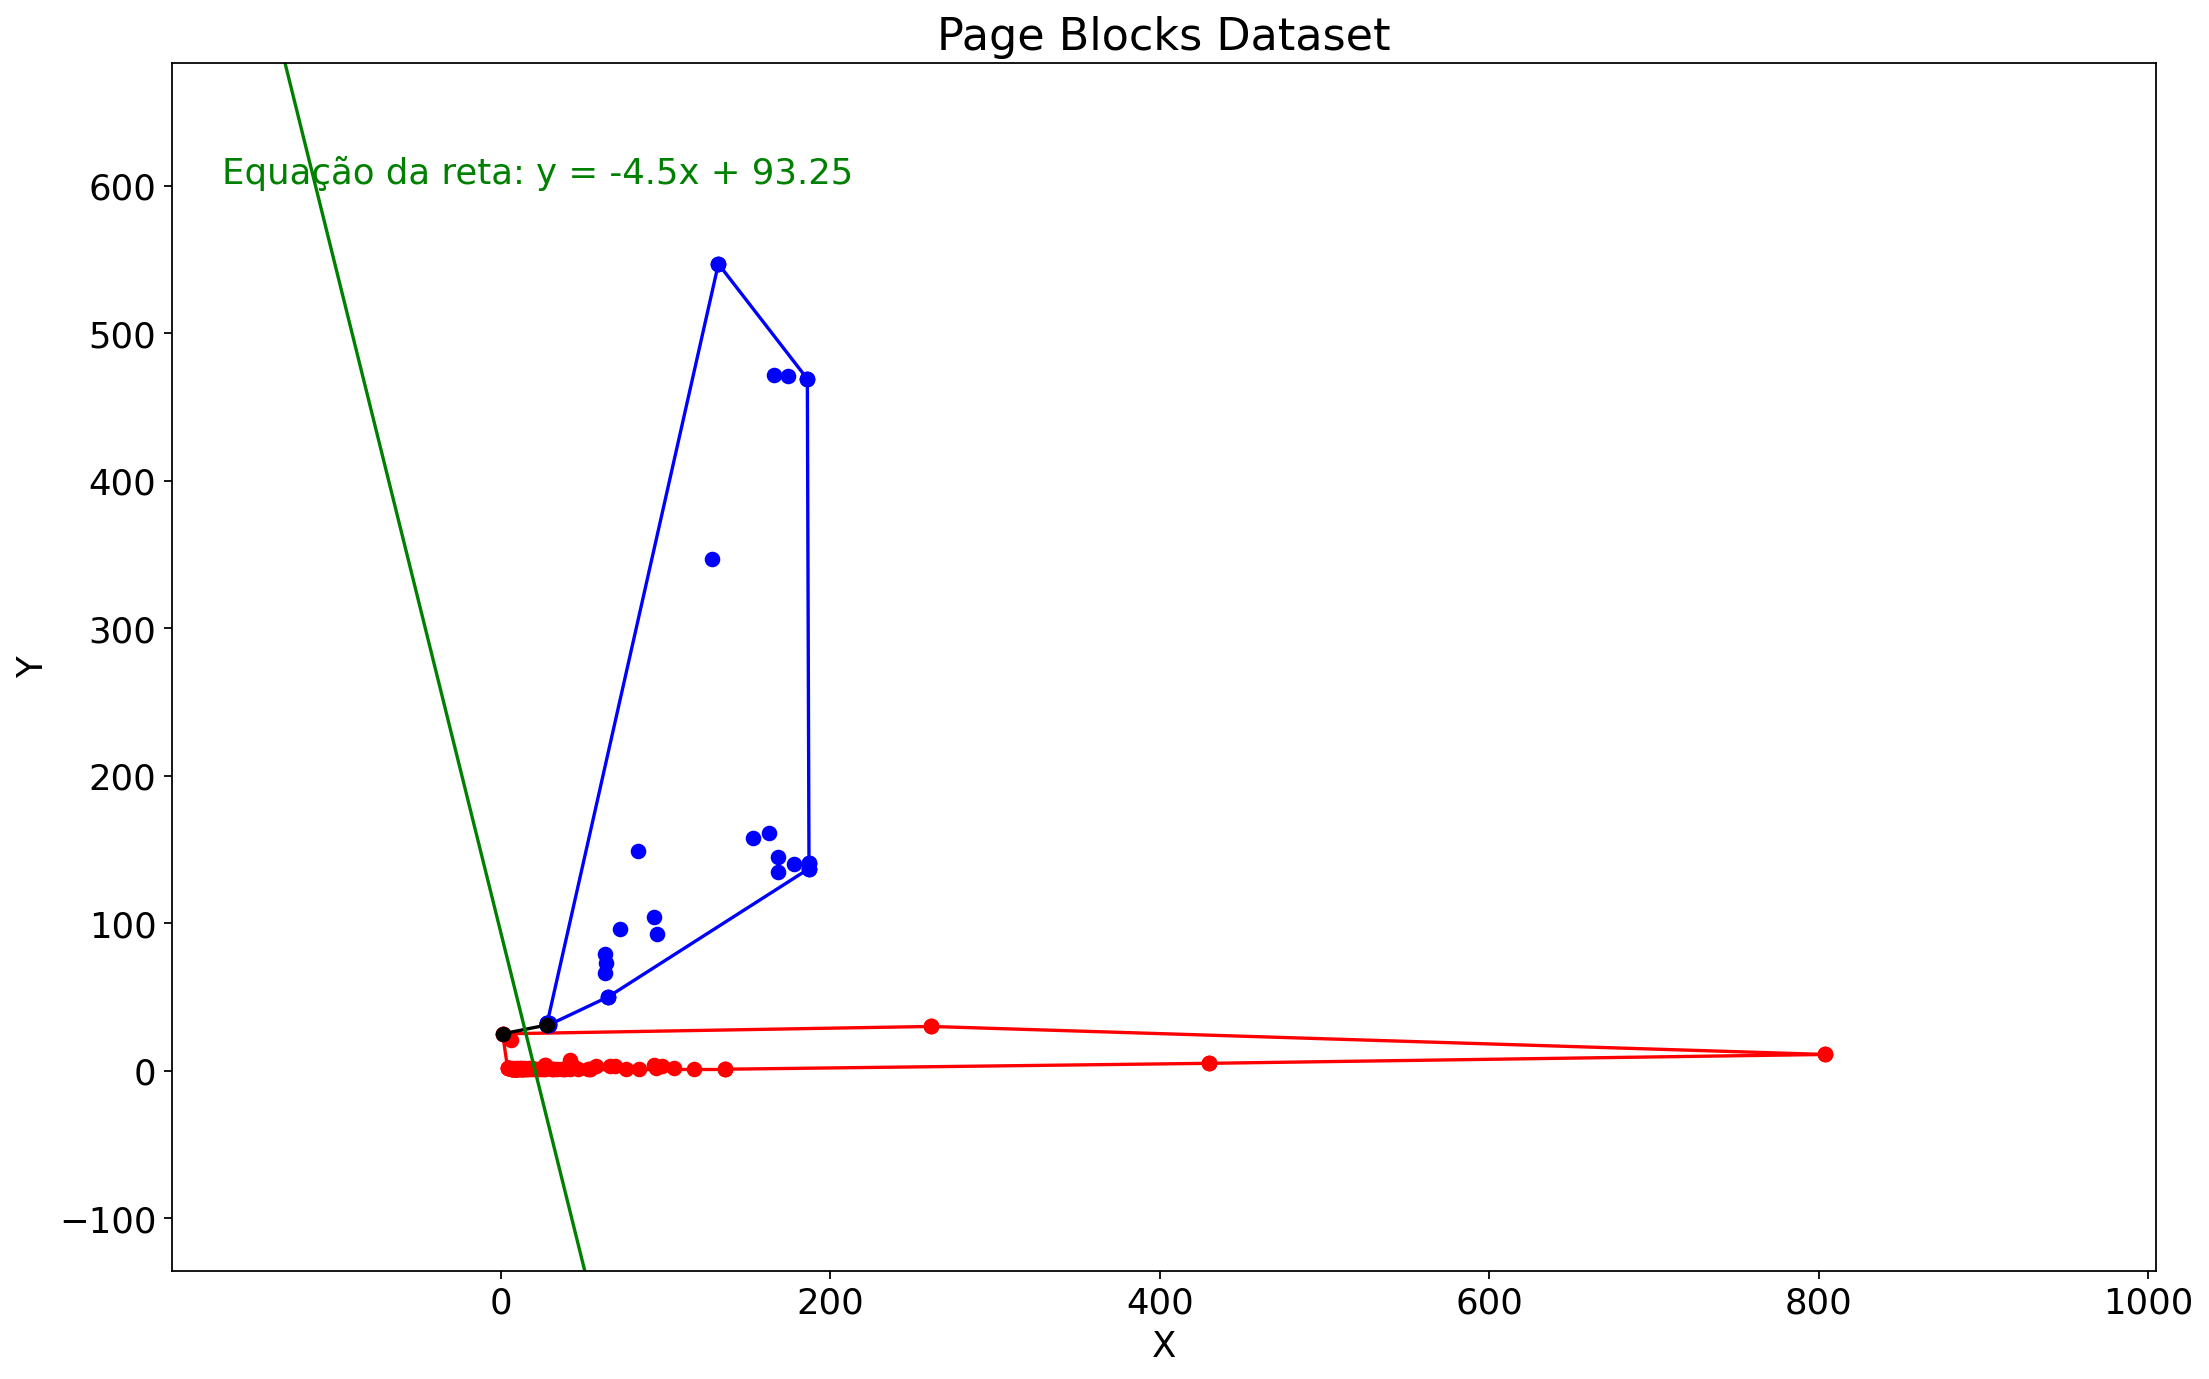

In [110]:
pageBlocks = readDatFile('datFiles/page-blocks.dat',', ')

pageBlocks = pageBlocks.replace({'Class':{4:0, 1:6 ,3:1}})
pageBlocks = pageBlocks.query("Class == 0 or Class == 1")
pageBlocks = pd.DataFrame({'X':pageBlocks['A1'],'Y':pageBlocks['A2'],'Class':pageBlocks['Class']})

findAndPlotModel(pageBlocks,"Page Blocks Dataset")

In [113]:
evaluateModel(pageBlocks)

As envoltórias convexas não se interceptam, portanto, os conjuntos são linearmente separáveis.
Avaliação do modelo:
Fold: 1
	Precisão: 0.3333333333333333
	Revocação: 1.0
	F-Score: 0.5
Fold: 2
	Precisão: 0.5
	Revocação: 1.0
	F-Score: 0.6666666666666666
Fold: 3
	Precisão: 0.46153846153846156
	Revocação: 1.0
	F-Score: 0.631578947368421
Fold: 4
	Precisão: 0.46153846153846156
	Revocação: 1.0
	F-Score: 0.631578947368421
Fold: 5
	Precisão: 0.6
	Revocação: 1.0
	F-Score: 0.7499999999999999


<ipython-input-79-14a5b8e4f956>:4: RuntimeWarning: divide by zero encountered in long_scalars
  slope = (convexHull[i+1].y - convexHull[i].y)/(convexHull[i+1].x - convexHull[i].x)


### Experimento Fars
O dataset em questão se refere à análise de acidentes fatais nos Estados Unidos, cada tipo de lesão é uma classe. Para esse experimento escolhemos as classes nenhuma lesão e lesões fatais, as duas classes não são linearmente separáveis.

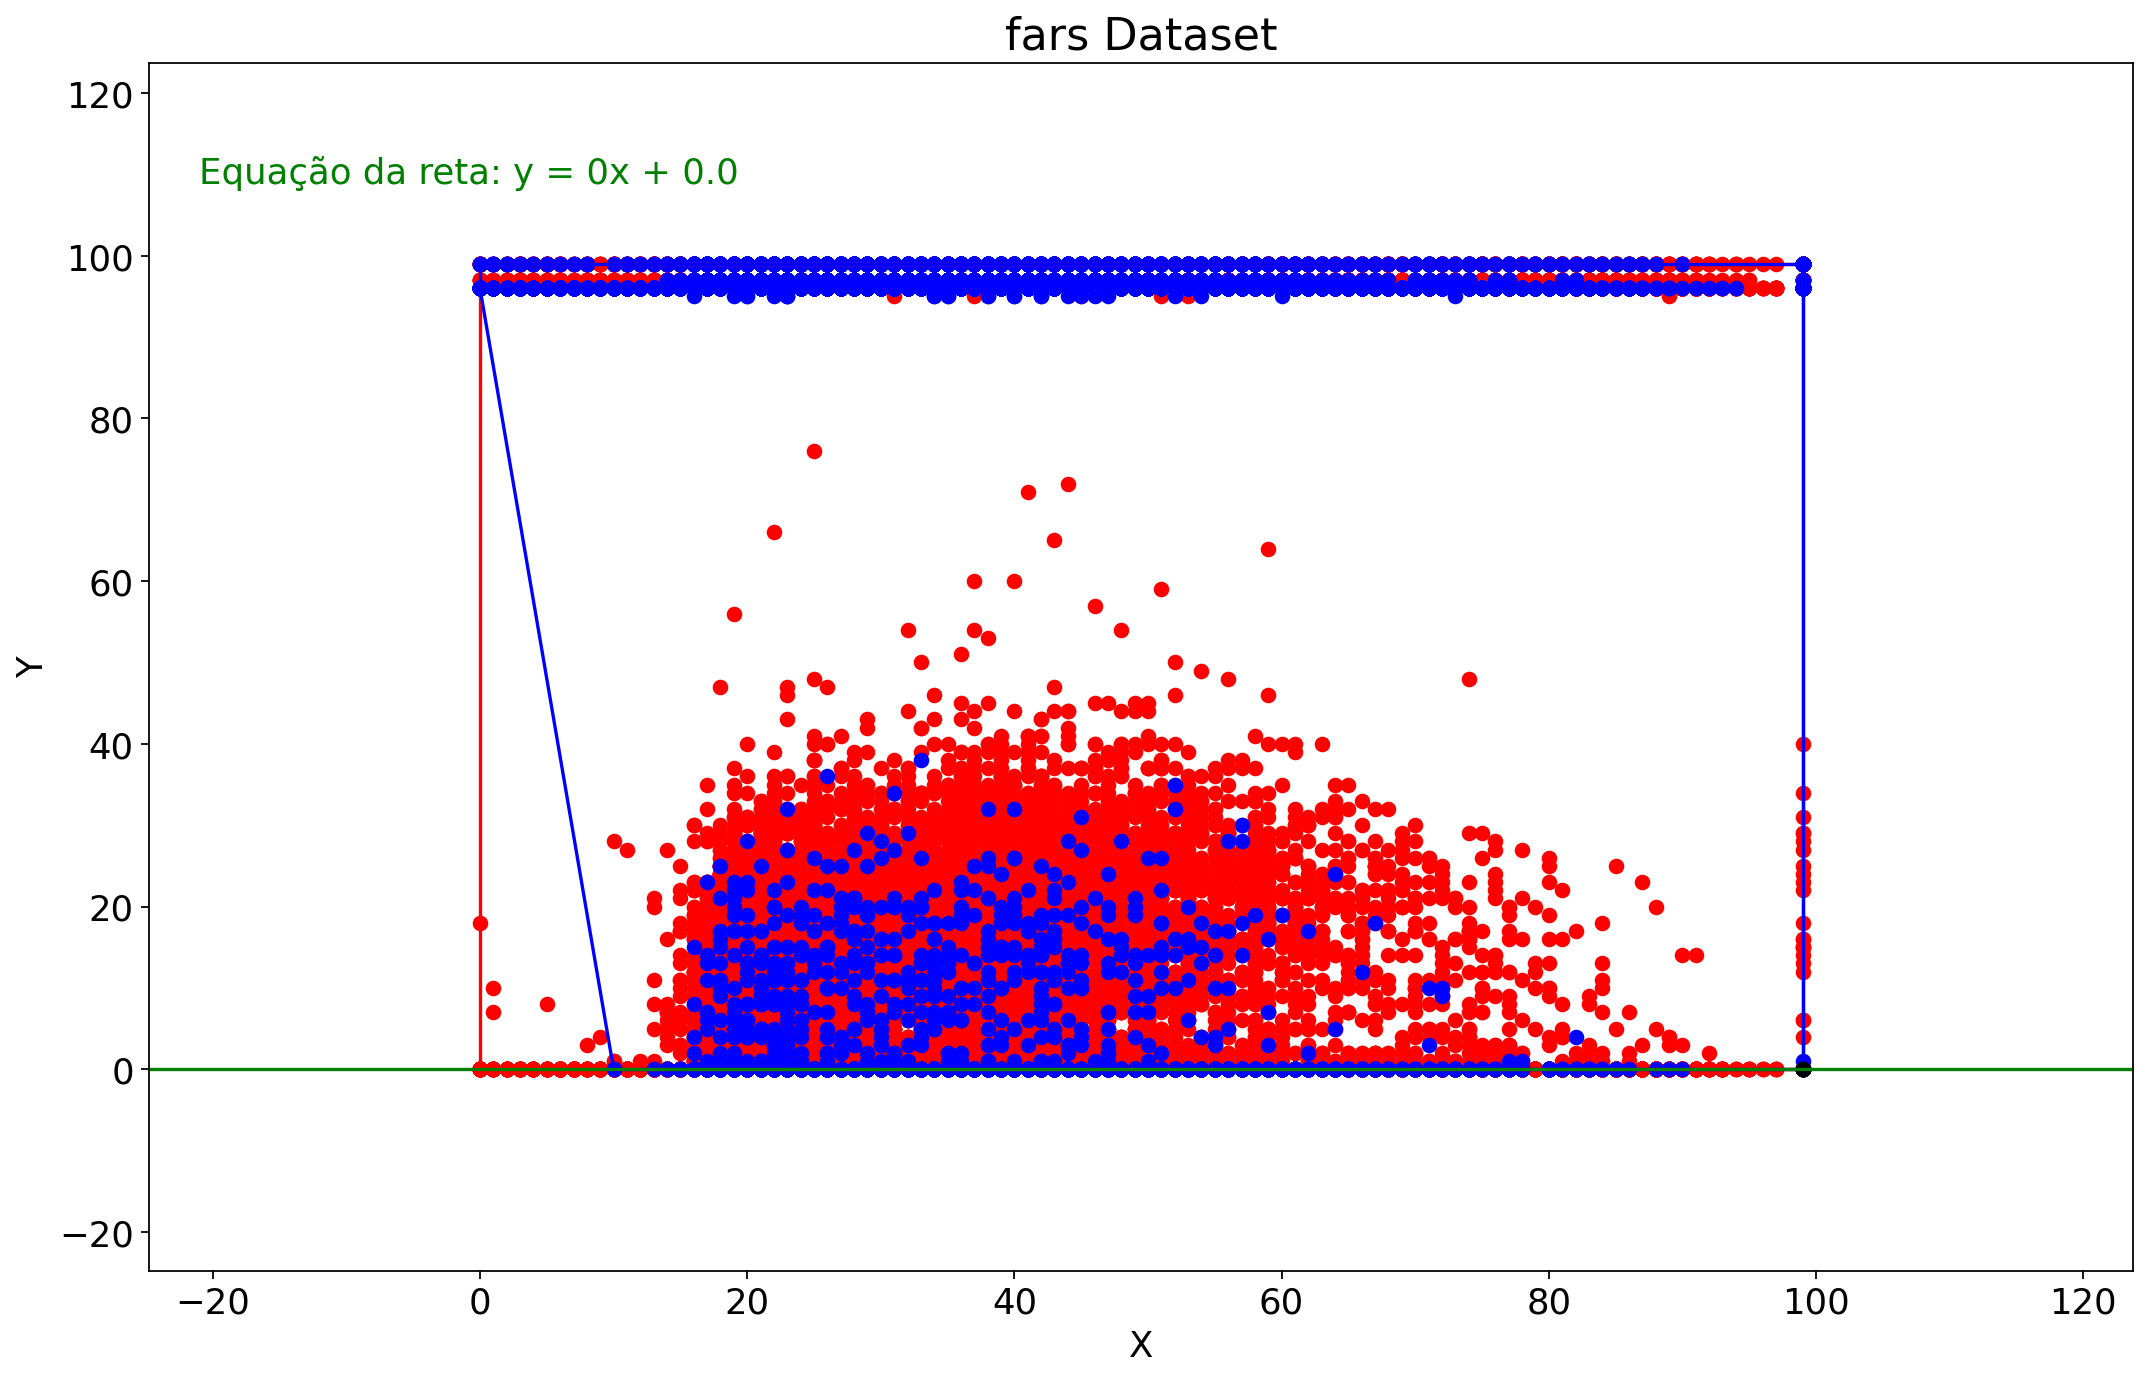

In [114]:
fars = readDatFile('datFiles/fars.dat',',')

fars = fars.replace({'Class':{'No_Injury':0,'Fatal_Injury':1}})
fars = fars.query("Class == 0 or Class == 1")
fars = pd.DataFrame({'X':fars['A2'],'Y':fars['A15'],'Class':fars['Class']})

findAndPlotModel(fars,"fars Dataset")

In [118]:
evaluateModel(fars)

As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.


### Experimento Magic
O dataset em questão se refere a uma simulação de partículas gamma de alta energia em uma atmosfera de Cherenkov, cada tipo de imagem das partículas gamma é uma classe. Para esse experimento existem as classes signal e background, as duas classes não são linearmente separáveis.

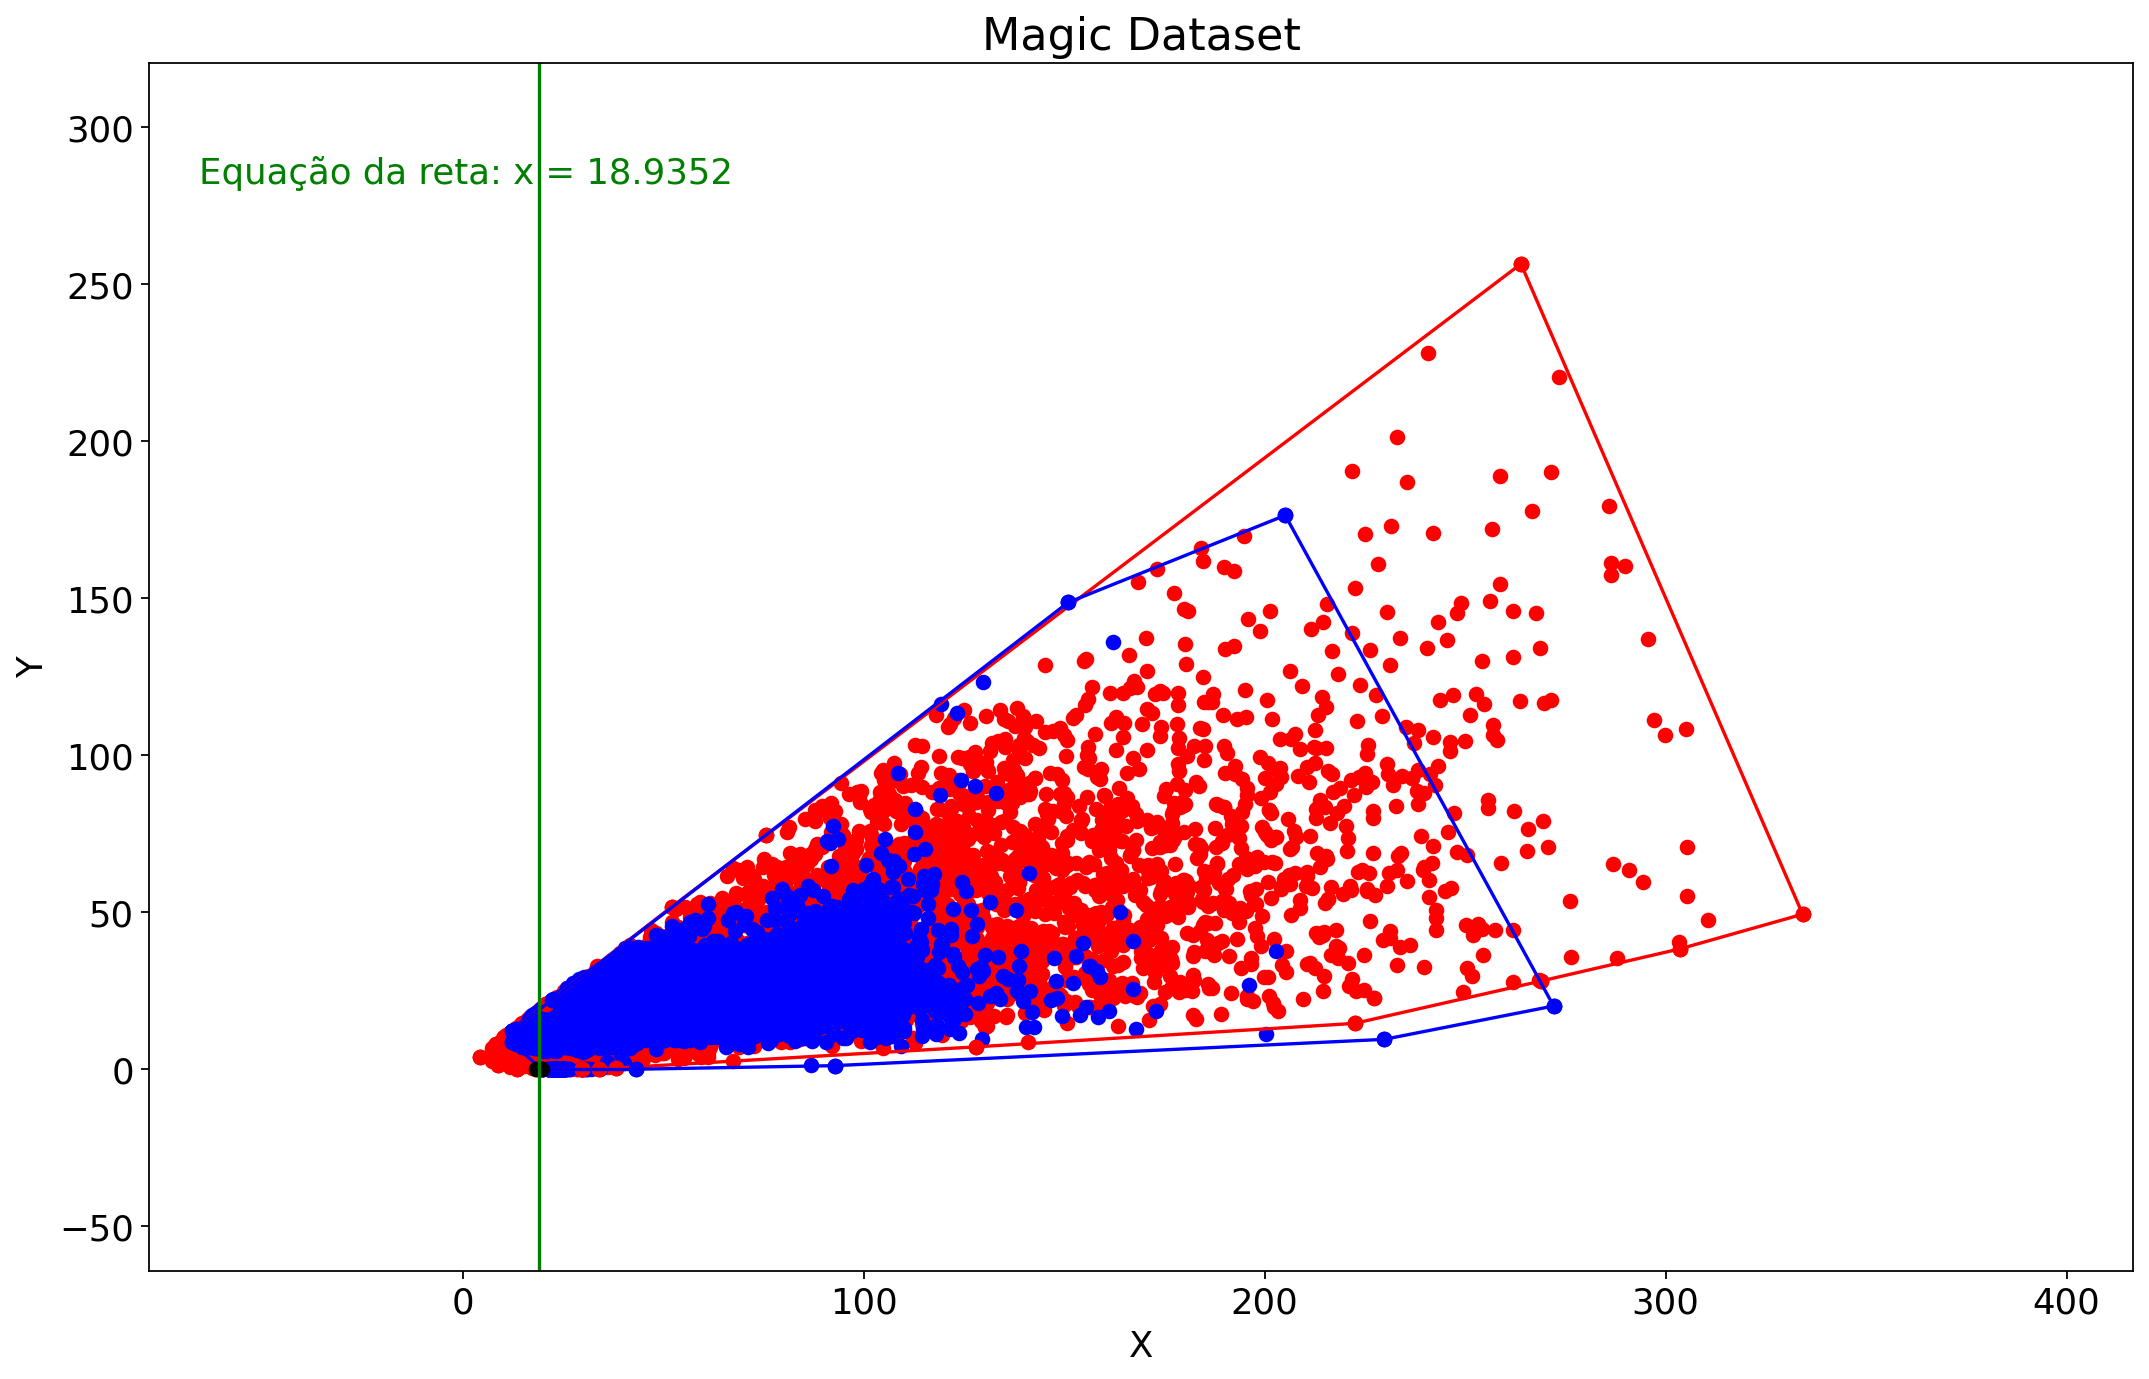

In [119]:
magic = readDatFile('datFiles/magic.dat',',')

magic = magic.replace({'Class':{'g':0,'h':1}})
magic = magic.query("Class == 0 or Class == 1")
magic = pd.DataFrame({'X':magic['FLength'],'Y':magic['FWidth'],'Class':magic['Class']})

findAndPlotModel(magic,"Magic Dataset")

In [120]:
evaluateModel(magic)

As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.
